In [1]:
# import psutil

# def get_cpu_load():
#     # Get CPU usage for each core
#     cpu_loads = psutil.cpu_percent(interval=1, percpu=True)
#     return cpu_loads

# def select_k_cpus_with_lowest_load(k):
#     # Get CPU usage for each core
#     cpu_loads = get_cpu_load()
    
#     # Create a list of tuples (core_id, load)
#     cpu_load_tuples = list(enumerate(cpu_loads))
    
#     # Sort the list based on load
#     sorted_cpu_loads = sorted(cpu_load_tuples, key=lambda x: x[1])
    
#     # Get the IDs of the K cores with lowest load
#     selected_cpus = [core[0] for core in sorted_cpu_loads[:k]]
    
#     return selected_cpus

# # Example usage
# k = 8  # Number of CPUs with lowest load
# selected_cpus = select_k_cpus_with_lowest_load(k)
# print(f"Selected {k} CPUs with lowest load:", selected_cpus)


In [2]:
!which python

/opt/anaconda3/envs/neuralteleportation/bin/python


In [3]:
# !pip install onnx==1.16.0

In [4]:
# !pip install numpy==1.26.4

In [5]:
# import os
# import psutil

# def set_cpu_affinity(pid, cpu_list):
#     try:
#         p = psutil.Process(pid)
#         p.cpu_affinity(cpu_list)
#         print(f"CPU affinity for process {pid} set to: {cpu_list}")
#     except psutil.NoSuchProcess:
#         print(f"Process with PID {pid} does not exist.")
#     except psutil.AccessDenied:
#         print("Permission denied. You may need sudo privileges to set CPU affinity.")

# # Get the process ID of the current process
# pid = os.getpid()

# # Set the CPU affinity to only CPU core 0
# cpu_list = [0, 1, 2, 3, 5, 6, 7, 8]
# set_cpu_affinity(pid, cpu_list)

In [6]:
import torch
print("Pytorch version:",torch.__version__)

Pytorch version: 2.4.0


In [7]:
import random
import math
import numpy as np
import os

import torch
from torch import nn
import torch.nn.functional as Fhtop

# import pytorch_lightning as pl

# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass


# uncomment for more descriptive logging 
import logging
FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
logging.basicConfig(format=FORMAT)

logging.getLogger().setLevel(logging.INFO)

## EZKL 

In [8]:
import argparse

import argparse

def get_args_parser(initial_args=None):
    parser = argparse.ArgumentParser('ConvNeXt training and evaluation script for image classification', add_help=False)
#     parser.add_argument('--batch_size', default=256, type=int,
#                         help='Per GPU batch size')
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--update_freq', default=1, type=int,
                        help='gradient accumulation steps')

    # Model parameters
#     parser.add_argument('--model', default='convnext_tiny', type=str, metavar='MODEL',
#                         help='Name of model to train')
    parser.add_argument('--input_size', default=224, type=int,
                        help='image input size')
    parser.add_argument('--layer_scale_init_value', default=1e-6, type=float,
                        help="Layer scale initial values")
    
    ########################## settings specific to this project ##########################
    
    # dropout and stochastic depth drop rate; set at most one to non-zero
    parser.add_argument('--dropout', type=float, default=0, metavar='PCT',
                        help='Drop path rate (default: 0.0)')
    parser.add_argument('--drop_path', type=float, default=0, metavar='PCT',
                        help='Drop path rate (default: 0.0)')
    
    # early / late dropout and stochastic depth settings
    parser.add_argument('--drop_mode', type=str, default='standard', choices=['standard', 'early', 'late'], help='drop mode')
    parser.add_argument('--drop_schedule', type=str, default='constant', choices=['constant', 'linear'], 
                        help='drop schedule for early dropout / s.d. only')
    parser.add_argument('--cutoff_epoch', type=int, default=0, 
                        help='if drop_mode is early / late, this is the epoch where dropout ends / starts')
    
    ####################################################################################### 
    
    # EMA related parameters
    parser.add_argument('--model_ema', type=str2bool, default=False)
    parser.add_argument('--model_ema_decay', type=float, default=0.9999, help='')
    parser.add_argument('--model_ema_force_cpu', type=str2bool, default=False, help='')
    parser.add_argument('--model_ema_eval', type=str2bool, default=False, help='Using ema to eval during training.')

    # Optimization parameters
    parser.add_argument('--opt', default='adamw', type=str, metavar='OPTIMIZER',
                        help='Optimizer (default: "adamw"')
    parser.add_argument('--opt_eps', default=1e-8, type=float, metavar='EPSILON',
                        help='Optimizer Epsilon (default: 1e-8)')
    parser.add_argument('--opt_betas', default=None, type=float, nargs='+', metavar='BETA',
                        help='Optimizer Betas (default: None, use opt default)')
    parser.add_argument('--clip_grad', type=float, default=None, metavar='NORM',
                        help='Clip gradient norm (default: None, no clipping)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.9)')
    parser.add_argument('--weight_decay', type=float, default=0.05,
                        help='weight decay (default: 0.05)')
    parser.add_argument('--weight_decay_end', type=float, default=None, help="""Final value of the
        weight decay. We use a cosine schedule for WD and using a larger decay by
        the end of training improves performance for ViTs.""")

    parser.add_argument('--lr', type=float, default=4e-3, metavar='LR',
                        help='learning rate (default: 4e-3), with total batch size 4096')
    parser.add_argument('--layer_decay', type=float, default=1.0)
    parser.add_argument('--min_lr', type=float, default=1e-6, metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0 (1e-6)')
    parser.add_argument('--warmup_epochs', type=int, default=50, metavar='N',
                        help='epochs to warmup LR, if scheduler supports')
    parser.add_argument('--warmup_steps', type=int, default=-1, metavar='N',
                        help='num of steps to warmup LR, will overload warmup_epochs if set > 0')

    # Augmentation parameters
    parser.add_argument('--color_jitter', type=float, default=0.4, metavar='PCT',
                        help='Color jitter factor (default: 0.4)')
    parser.add_argument('--aa', type=str, default='rand-m9-mstd0.5-inc1', metavar='NAME',
                        help='Use AutoAugment policy. "v0" or "original". " + "(default: rand-m9-mstd0.5-inc1)'),
    parser.add_argument('--smoothing', type=float, default=0.1,
                        help='Label smoothing (default: 0.1)')
    parser.add_argument('--train_interpolation', type=str, default='bicubic',
                        help='Training interpolation (random, bilinear, bicubic default: "bicubic")')

    # Evaluation parameters
    parser.add_argument('--crop_pct', type=float, default=None)

    # * Random Erase params
    parser.add_argument('--reprob', type=float, default=0.25, metavar='PCT',
                        help='Random erase prob (default: 0.25)')
    parser.add_argument('--remode', type=str, default='pixel',
                        help='Random erase mode (default: "pixel")')
    parser.add_argument('--recount', type=int, default=1,
                        help='Random erase count (default: 1)')
    parser.add_argument('--resplit', type=str2bool, default=False,
                        help='Do not random erase first (clean) augmentation split')

    # * Mixup params
    parser.add_argument('--mixup', type=float, default=0.8,
                        help='mixup alpha, mixup enabled if > 0.')
    parser.add_argument('--cutmix', type=float, default=1.0,
                        help='cutmix alpha, cutmix enabled if > 0.')
    parser.add_argument('--cutmix_minmax', type=float, nargs='+', default=None,
                        help='cutmix min/max ratio, overrides alpha and enables cutmix if set (default: None)')
    parser.add_argument('--mixup_prob', type=float, default=1.0,
                        help='Probability of performing mixup or cutmix when either/both is enabled')
    parser.add_argument('--mixup_switch_prob', type=float, default=0.5,
                        help='Probability of switching to cutmix when both mixup and cutmix enabled')
    parser.add_argument('--mixup_mode', type=str, default='batch',
                        help='How to apply mixup/cutmix params. Per "batch", "pair", or "elem"')

    # * Finetuning params
    parser.add_argument('--finetune', default='',
                        help='finetune from checkpoint')
    parser.add_argument('--head_init_scale', default=1.0, type=float,
                        help='classifier head initial scale, typically adjusted in fine-tuning')
    parser.add_argument('--model_key', default='model|module', type=str,
                        help='which key to load from saved state dict, usually model or model_ema')
    parser.add_argument('--model_prefix', default='', type=str)

    # Dataset parameters
#     parser.add_argument('--data_path', default='/datasets01/imagenet_full_size/061417/', type=str,
#                         help='dataset path')
    parser.add_argument('--eval_data_path', default=None, type=str,
                        help='dataset path for evaluation')
    parser.add_argument('--nb_classes', default=1000, type=int,
                        help='number of the classification types')
    parser.add_argument('--imagenet_default_mean_and_std', type=str2bool, default=True)
    parser.add_argument('--data_set', default='IMNET', choices=['CIFAR', 'IMNET', 'image_folder'],
                        type=str, help='ImageNet dataset path')
    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int)

#     parser.add_argument('--resume', default='',
#                         help='resume from checkpoint')
    parser.add_argument('--auto_resume', type=str2bool, default=True)
    parser.add_argument('--save_ckpt', type=str2bool, default=True)
    parser.add_argument('--save_ckpt_freq', default=1, type=int)
    parser.add_argument('--save_ckpt_num', default=3, type=int)

    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', type=str2bool, default=False,
                        help='Perform evaluation only')
    parser.add_argument('--dist_eval', type=str2bool, default=True,
                        help='Enabling distributed evaluation')
    parser.add_argument('--disable_eval', type=str2bool, default=False,
                        help='Disabling evaluation during training')
    parser.add_argument('--num_workers', default=10, type=int)
    parser.add_argument('--pin_mem', type=str2bool, default=True,
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--local_rank', default=-1, type=int)
    parser.add_argument('--dist_on_itp', type=str2bool, default=False)
    parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')

    parser.add_argument('--use_amp', type=str2bool, default=False, 
                        help="Use PyTorch's AMP (Automatic Mixed Precision) or not")

    # Weights and Biases arguments
    parser.add_argument('--enable_wandb', type=str2bool, default=False,
                        help="enable logging to Weights and Biases")
    parser.add_argument('--project', default='convnext', type=str,
                        help="The name of the W&B project where you're sending the new run.")
    parser.add_argument('--wandb_ckpt', type=str2bool, default=False,
                        help="Save model checkpoints as W&B Artifacts.")

    # arguments for pruning
    parser.add_argument("--nsamples", type=int, default=4096)
#     parser.add_argument("--sparsity", type=float, default=0.)
    parser.add_argument("--prune_metric", type=str, choices=["magnitude", "wanda"])
    parser.add_argument("--prune_granularity", type=str)
    parser.add_argument("--blocksize", type=int, default=1)

    return parser

def str2bool(v):
    """
    Converts string to bool type; enables command line 
    arguments in the format of '--arg1 true --arg2 false'
    """
    if isinstance(v, bool):
        return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')

In [9]:
class DefaultArgs:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

def get_default_args():
    parser = get_args_parser()
    default_args = {}
    for action in parser._actions:
        # Check if action is an argument
        if not action.option_strings:
            continue
        # Use the destination as the key and the default value as the value
        default_args[action.dest] = action.default
    return DefaultArgs(**default_args)

# Example usage:
default_args = get_default_args()
args = default_args

In [10]:
# # ===== IMPORTANT: INPUT FLAGS OF PYTHON CODE HERE =====

# args.model = "vit_tiny"
# args.data_path = "/rds/general/user/mm6322/home/imagenet"

# args.resume = "/rds/general/user/mm6322/home/verifiable_NN_ezkl/examples/notebooks/CAP_pruned_models/Checkpoints/deit_tiny_patch16_224_sparsity=0.50_best.pth"
# #args.resume = "/rds/general/user/mm6322/home/sparse_wanda/image_classifiers/outputs/vit_tiny/pruned_vit_tiny.pth"
# # args.resume = "/rds/general/user/mm6322/home/sparse_wanda/image_classifiers/model_weights/deit/deit_tiny_patch16_224-a1311bcf.pth"


# args.sparsity = 0.5
# args.batch_size = 32

# args.pruning_method = "CAP" # DENSE,CAP,WANDA

# # args.prune_metric = "wanda"
# # args.prune_granularity = "row"
# # pruned_model_dir = "/rds/general/user/mm6322/home/sparse_wanda/image_classifiers/outputs/vit_tiny/pruned_vit_tiny.pth"

# # Prefix directory
# args.prefix_dir = "sparse-cap-acc/" #sparse-cap-acc, dense-acc, sparse-wanda-acc
# os.makedirs(args.prefix_dir, exist_ok=True)

# # EZKL HPs
# args.input_param_scale = 7
# args.log_rows = 20
# args.num_cols = 4
# args.scale_rebase_multiplier = 1

In [11]:
import os
import argparse

# Check if running in Jupyter Notebook
try:
    from IPython import get_ipython
    if 'IPKernelApp' in get_ipython().config:
        IN_JUPYTER = True
    else:
        IN_JUPYTER = False
except:
    IN_JUPYTER = False

# Define default values
default_model = "vit_tiny"
default_data_path = "/rds/general/user/mm6322/home/imagenet"
default_resume = "/Users/mm6322/Phd research/nerual_transport/neuralteleportation/neuralteleportation/experiments/sparse-cap-acc-tmp/deit_tiny_patch16_224_sparsity=0.50_best.pth"
# default_resume = "/rds/general/user/mm6322/home/verifiable_NN_ezkl/examples/notebooks/CAP_pruned_models/Checkpoints/deit_tiny_patch16_224_sparsity=0.50_best.pth"
default_sparsity = 0.5
default_batch_size = 1
default_pruning_method = "CAP"
default_prefix_dir = "sparse-cap-acc-tmp/"
default_input_param_scale = 7
default_log_rows = 20
default_num_cols = 2
default_scale_rebase_multiplier = 1

# Parse command-line arguments if not in Jupyter Notebook
if not IN_JUPYTER:
    parser = argparse.ArgumentParser(description='Process some integers.')
    parser.add_argument('--model', default=default_model, type=str, help='Model type')
    parser.add_argument('--data_path', default=default_data_path, type=str, help='Data path')
    parser.add_argument('--resume', default=default_resume, type=str, help='Resume path')
    parser.add_argument('--sparsity', default=default_sparsity, type=float, help='Sparsity value')
    parser.add_argument('--batch_size', default=default_batch_size, type=int, help='Batch size')
    parser.add_argument('--pruning_method', default=default_pruning_method, type=str, help='Pruning method')
    parser.add_argument('--prefix_dir', default=default_prefix_dir, type=str, help='Prefix directory')
    parser.add_argument('--input_param_scale', default=default_input_param_scale, type=int, help='Input parameter scale')
    parser.add_argument('--log_rows', default=default_log_rows, type=int, help='Log rows')
    parser.add_argument('--num_cols', default=default_num_cols, type=int, help='Number of columns')
    parser.add_argument('--scale_rebase_multiplier', default=default_scale_rebase_multiplier, type=int, help='Scale rebase multiplier')

    args = parser.parse_args(namespace=args)
else:
    # In Jupyter Notebook, define args with default values
    args.model = default_model
    args.data_path = default_data_path
    args.resume = default_resume
    args.sparsity = default_sparsity
    args.batch_size = default_batch_size
    args.pruning_method = default_pruning_method
    args.prefix_dir = default_prefix_dir
    args.input_param_scale = default_input_param_scale
    args.log_rows = default_log_rows
    args.num_cols = default_num_cols
    args.scale_rebase_multiplier = default_scale_rebase_multiplier
    
    
print("\n ---- IN_JUPYTER:",str(IN_JUPYTER),"---- ")
# Print values for verification
print("Model:", args.model)
print("Data Path:", args.data_path)
print("Resume Path:", args.resume)
print("Sparsity:", args.sparsity)
print("Batch Size:", args.batch_size)
print("Pruning Method:", args.pruning_method)
print("Prefix Directory:", args.prefix_dir)
print("Input Parameter Scale:", args.input_param_scale)
print("Log Rows:", args.log_rows)
print("Number of Columns:", args.num_cols)
print("Scale Rebase Multiplier:", args.scale_rebase_multiplier)
print("-------- \n\n\n")

os.makedirs(args.prefix_dir, exist_ok=True)


 ---- IN_JUPYTER: True ---- 
Model: vit_tiny
Data Path: /rds/general/user/mm6322/home/imagenet
Resume Path: /Users/mm6322/Phd research/nerual_transport/neuralteleportation/neuralteleportation/experiments/sparse-cap-acc-tmp/deit_tiny_patch16_224_sparsity=0.50_best.pth
Sparsity: 0.5
Batch Size: 1
Pruning Method: CAP
Prefix Directory: sparse-cap-acc-tmp/
Input Parameter Scale: 7
Log Rows: 20
Number of Columns: 2
Scale Rebase Multiplier: 1
-------- 





In [12]:
for key, value in vars(args).items():
    print(f"{key}: {value}")

epochs: 300
update_freq: 1
input_size: 224
layer_scale_init_value: 1e-06
dropout: 0
drop_path: 0
drop_mode: standard
drop_schedule: constant
cutoff_epoch: 0
model_ema: False
model_ema_decay: 0.9999
model_ema_force_cpu: False
model_ema_eval: False
opt: adamw
opt_eps: 1e-08
opt_betas: None
clip_grad: None
momentum: 0.9
weight_decay: 0.05
weight_decay_end: None
lr: 0.004
layer_decay: 1.0
min_lr: 1e-06
warmup_epochs: 50
warmup_steps: -1
color_jitter: 0.4
aa: rand-m9-mstd0.5-inc1
smoothing: 0.1
train_interpolation: bicubic
crop_pct: None
reprob: 0.25
remode: pixel
recount: 1
resplit: False
mixup: 0.8
cutmix: 1.0
cutmix_minmax: None
mixup_prob: 1.0
mixup_switch_prob: 0.5
mixup_mode: batch
finetune: 
head_init_scale: 1.0
model_key: model|module
model_prefix: 
eval_data_path: None
nb_classes: 1000
imagenet_default_mean_and_std: True
data_set: IMNET
output_dir: 
device: cuda
seed: 0
auto_resume: True
save_ckpt: True
save_ckpt_freq: 1
save_ckpt_num: 3
start_epoch: 0
eval: False
dist_eval: True
d

In [13]:
if args.output_dir:
    Path(default_args_dict.output_dir).mkdir(parents=True, exist_ok=True)

In [14]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import os
from torchvision import datasets, transforms

from timm.data.constants import \
    IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from timm.data import create_transform

def build_dataset(is_train, args):
    transform = build_transform(is_train, args)

    print("Transform = ")
    if isinstance(transform, tuple):
        for trans in transform:
            print(" - - - - - - - - - - ")
            for t in trans.transforms:
                print(t)
    else:
        for t in transform.transforms:
            print(t)
    print("---------------------------")

    if args.data_set == 'CIFAR':
        dataset = datasets.CIFAR100(args.data_path, train=is_train, transform=transform, download=True)
        nb_classes = 100
    elif args.data_set == 'IMNET':
        print("reading from datapath", args.data_path)
        root = os.path.join(args.data_path, 'train' if is_train else 'val_dirs')
        dataset = datasets.ImageFolder(root, transform=transform)
        nb_classes = 1000
    elif args.data_set == "image_folder":
        root = args.data_path if is_train else args.eval_data_path
        dataset = datasets.ImageFolder(root, transform=transform)
        nb_classes = args.nb_classes
        assert len(dataset.class_to_idx) == nb_classes
    else:
        raise NotImplementedError()
    print("Number of the class = %d" % nb_classes)

    return dataset, nb_classes


def build_transform(is_train, args):
    resize_im = args.input_size > 32
    imagenet_default_mean_and_std = args.imagenet_default_mean_and_std
    mean = IMAGENET_INCEPTION_MEAN if not imagenet_default_mean_and_std else IMAGENET_DEFAULT_MEAN
    std = IMAGENET_INCEPTION_STD if not imagenet_default_mean_and_std else IMAGENET_DEFAULT_STD

    if is_train:
        # this should always dispatch to transforms_imagenet_train
        transform = create_transform(
            input_size=args.input_size,
            is_training=True,
            color_jitter=args.color_jitter,
            auto_augment=args.aa,
            interpolation=args.train_interpolation,
            re_prob=args.reprob,
            re_mode=args.remode,
            re_count=args.recount,
            mean=mean,
            std=std,
        )
        if not resize_im:
            transform.transforms[0] = transforms.RandomCrop(
                args.input_size, padding=4)
        return transform

    t = []
    if resize_im:
        # warping (no cropping) when evaluated at 384 or larger
        if args.input_size >= 384:  
            t.append(
            transforms.Resize((args.input_size, args.input_size), 
                            interpolation=transforms.InterpolationMode.BICUBIC), 
        )
            print(f"Warping {args.input_size} size input images...")
        else:
            if args.crop_pct is None:
                args.crop_pct = 224 / 256
            size = int(args.input_size / args.crop_pct)
            t.append(
                # to maintain same ratio w.r.t. 224 images
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC),  
            )
            t.append(transforms.CenterCrop(args.input_size))

    t.append(transforms.ToTensor())
    t.append(transforms.Normalize(mean, std))
    return transforms.Compose(t)


/opt/anaconda3/envs/neuralteleportation/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# dataset_train, args.nb_classes = build_dataset(is_train=True, args=args)

In [16]:
# sampler_train = torch.utils.data.DistributedSampler(
#         dataset_train, num_replicas=1, rank=0, shuffle=True, seed=args.seed,
# )

In [17]:
# data_loader_train = torch.utils.data.DataLoader(
#     dataset_train, sampler=sampler_train,
#     batch_size=args.batch_size,
#     num_workers=args.num_workers,
#     pin_memory=args.pin_mem,
#     drop_last=True,
# )

In [18]:
import timm
timm.__version__

'0.4.12'

In [19]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import os
import math
import time
from collections import defaultdict, deque
import datetime
import numpy as np
from timm.utils import get_state_dict

from pathlib import Path
from timm.models import create_model
import torch
import torch.distributed as dist
# from torch._six import inf

class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if v is None:
                continue
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = [
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}'
        ]
        if torch.cuda.is_available():
            log_msg.append('max mem: {memory:.0f}')
        log_msg = self.delimiter.join(log_msg)
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


class TensorboardLogger(object):
    def __init__(self, log_dir):
        self.writer = SummaryWriter(logdir=log_dir)
        self.step = 0

    def set_step(self, step=None):
        if step is not None:
            self.step = step
        else:
            self.step += 1

    def update(self, head='scalar', step=None, **kwargs):
        for k, v in kwargs.items():
            if v is None:
                continue
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.writer.add_scalar(head + "/" + k, v, self.step if step is None else step)

    def flush(self):
        self.writer.flush()


class WandbLogger(object):
    def __init__(self, args):
        self.args = args

        try:
            import wandb
            self._wandb = wandb
        except ImportError:
            raise ImportError(
                "To use the Weights and Biases Logger please install wandb."
                "Run `pip install wandb` to install it."
            )

        # Initialize a W&B run 
        if self._wandb.run is None:
            self._wandb.init(
                project=args.project,
                config=args
            )

    def log_epoch_metrics(self, metrics, commit=True):
        """
        Log train/test metrics onto W&B.
        """
        # Log number of model parameters as W&B summary
        self._wandb.summary['n_parameters'] = metrics.get('n_parameters', None)
        metrics.pop('n_parameters', None)

        # Log current epoch
        self._wandb.log({'epoch': metrics.get('epoch')}, commit=False)
        metrics.pop('epoch')

        for k, v in metrics.items():
            if 'train' in k:
                self._wandb.log({f'Global Train/{k}': v}, commit=False)
            elif 'test' in k:
                self._wandb.log({f'Global Test/{k}': v}, commit=False)

        self._wandb.log({})

    def log_checkpoints(self):
        output_dir = self.args.output_dir
        model_artifact = self._wandb.Artifact(
            self._wandb.run.id + "_model", type="model"
        )

        model_artifact.add_dir(output_dir)
        self._wandb.log_artifact(model_artifact, aliases=["latest", "best"])

    def set_steps(self):
        # Set global training step
        self._wandb.define_metric('Rank-0 Batch Wise/*', step_metric='Rank-0 Batch Wise/global_train_step')
        # Set epoch-wise step
        self._wandb.define_metric('Global Train/*', step_metric='epoch')
        self._wandb.define_metric('Global Test/*', step_metric='epoch')


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):

    if args.dist_on_itp:
        args.rank = int(os.environ['OMPI_COMM_WORLD_RANK'])
        args.world_size = int(os.environ['OMPI_COMM_WORLD_SIZE'])
        args.gpu = int(os.environ['OMPI_COMM_WORLD_LOCAL_RANK'])
        args.dist_url = "tcp://%s:%s" % (os.environ['MASTER_ADDR'], os.environ['MASTER_PORT'])
        os.environ['LOCAL_RANK'] = str(args.gpu)
        os.environ['RANK'] = str(args.rank)
        os.environ['WORLD_SIZE'] = str(args.world_size)
        # ["RANK", "WORLD_SIZE", "MASTER_ADDR", "MASTER_PORT", "LOCAL_RANK"]
    elif 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()

        os.environ['RANK'] = str(args.rank)
        os.environ['LOCAL_RANK'] = str(args.gpu)
        os.environ['WORLD_SIZE'] = str(args.world_size)
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}, gpu {}'.format(
        args.rank, args.dist_url, args.gpu), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)


def load_state_dict(model, state_dict, prefix='', ignore_missing="relative_position_index"):
    missing_keys = []
    unexpected_keys = []
    error_msgs = []
    # copy state_dict so _load_from_state_dict can modify it
    metadata = getattr(state_dict, '_metadata', None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata
        
    pattern = re.compile(r'^blocks\.(\d+)\.attn\.q\.weight$')
    state_dict_keys = list(state_dict.keys())
    
    for key in state_dict_keys:
        match = pattern.match(key)
        if match:
            index = int(match.group(1))
            query_key = key
            key_key = key.replace("q","k")
            value_key = key.replace("q","v")
            
            new_name = "blocks." + str(index) +".attn.qkv.weight"
            state_dict[new_name] = torch.cat([state_dict[query_key], state_dict[key_key], state_dict[value_key]], dim=0)
            
            print("index:",index,"\t new_name:",new_name)
            del state_dict[query_key], state_dict[key_key], state_dict[value_key]
            
    
    pattern = re.compile(r'^blocks\.(\d+)\.attn\.q\.bias$')
    
    for key in state_dict_keys:
        match = pattern.match(key)
        if match:
            index = int(match.group(1))
            query_key = key
            key_key = key.replace("q","k")
            value_key = key.replace("q","v")
            
            new_name = "blocks." + str(index) +".attn.qkv.bias"
            state_dict[new_name] = torch.cat([state_dict[query_key], state_dict[key_key], state_dict[value_key]], dim=0)
            
            print("index:",index,"\t new_name:",new_name)
            del state_dict[query_key], state_dict[key_key], state_dict[value_key]
                                              
    

    def load(module, prefix=''):
        local_metadata = {} if metadata is None else metadata.get(
            prefix[:-1], {})
        module._load_from_state_dict(
            state_dict, prefix, local_metadata, True, missing_keys, unexpected_keys, error_msgs)
        for name, child in module._modules.items():
            if child is not None:
                load(child, prefix + name + '.')

    load(model, prefix=prefix)

    warn_missing_keys = []
    ignore_missing_keys = []
    for key in missing_keys:
        keep_flag = True
        for ignore_key in ignore_missing.split('|'):
            if ignore_key in key:
                keep_flag = False
                break
        if keep_flag:
            warn_missing_keys.append(key)
        else:
            ignore_missing_keys.append(key)
            

    missing_keys = warn_missing_keys

    if len(missing_keys) > 0:
        print("Weights of {} not initialized from pretrained model: {}".format(
            model.__class__.__name__, missing_keys))
    if len(unexpected_keys) > 0:
        print("Weights from pretrained model not used in {}: {}".format(
            model.__class__.__name__, unexpected_keys))
    if len(ignore_missing_keys) > 0:
        print("Ignored weights of {} not initialized from pretrained model: {}".format(
            model.__class__.__name__, ignore_missing_keys))
    if len(error_msgs) > 0:
        print('\n'.join(error_msgs))


class NativeScalerWithGradNormCount:
    state_dict_key = "amp_scaler"

    def __init__(self):
        self._scaler = torch.cuda.amp.GradScaler()

    def __call__(self, loss, optimizer, clip_grad=None, parameters=None, create_graph=False, update_grad=True):
        self._scaler.scale(loss).backward(create_graph=create_graph)

        ########################################################
        ## Code I added 
        for param in parameters:
            weight_copy = param.data.abs().clone()
            mask = weight_copy.gt(0).float().cuda()
            sparsity = mask.sum() / mask.numel()
            if sparsity > 0.3:
                # non-trivial sparsity 
                param.grad.data.mul_(mask)
        ########################################################

        if update_grad:
            if clip_grad is not None:
                assert parameters is not None
                self._scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params in-place
                norm = torch.nn.utils.clip_grad_norm_(parameters, clip_grad)
            else:
                self._scaler.unscale_(optimizer)
                norm = get_grad_norm_(parameters)
            self._scaler.step(optimizer)
            self._scaler.update()
        else:
            norm = None
        return norm

    def state_dict(self):
        return self._scaler.state_dict()

    def load_state_dict(self, state_dict):
        self._scaler.load_state_dict(state_dict)


def get_grad_norm_(parameters, norm_type: float = 2.0) -> torch.Tensor:
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    if len(parameters) == 0:
        return torch.tensor(0.)
    device = parameters[0].grad.device
    if norm_type == inf:
        total_norm = max(p.grad.detach().abs().max().to(device) for p in parameters)
    else:
        total_norm = torch.norm(torch.stack([torch.norm(p.grad.detach(), norm_type).to(device) for p in parameters]), norm_type)
    return total_norm


def cosine_scheduler(base_value, final_value, epochs, niter_per_ep, warmup_epochs=0,
                     start_warmup_value=0, warmup_steps=-1):
    warmup_schedule = np.array([])
    warmup_iters = warmup_epochs * niter_per_ep
    if warmup_steps > 0:
        warmup_iters = warmup_steps
    print("Set warmup steps = %d" % warmup_iters)
    if warmup_epochs > 0:
        warmup_schedule = np.linspace(start_warmup_value, base_value, warmup_iters)

    iters = np.arange(epochs * niter_per_ep - warmup_iters)
    schedule = np.array(
        [final_value + 0.5 * (base_value - final_value) * (1 + math.cos(math.pi * i / (len(iters)))) for i in iters])

    schedule = np.concatenate((warmup_schedule, schedule))

    assert len(schedule) == epochs * niter_per_ep
    return schedule

def save_model(args, epoch, model, model_without_ddp, optimizer, loss_scaler, model_ema=None):
    output_dir = Path(args.output_dir)
    epoch_name = str(epoch)
    checkpoint_paths = [output_dir / ('checkpoint-%s.pth' % epoch_name)]
    for checkpoint_path in checkpoint_paths:
        to_save = {
            'model': model_without_ddp.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'scaler': loss_scaler.state_dict(),
            'args': args,
        }

        if model_ema is not None:
            to_save['model_ema'] = get_state_dict(model_ema)

        save_on_master(to_save, checkpoint_path)

    if is_main_process() and isinstance(epoch, int):
        to_del = epoch - args.save_ckpt_num * args.save_ckpt_freq
        old_ckpt = output_dir / ('checkpoint-%s.pth' % to_del)
        if os.path.exists(old_ckpt):
            os.remove(old_ckpt)


def auto_load_model(args, model, model_without_ddp, optimizer, loss_scaler, model_ema=None):
    output_dir = Path(args.output_dir)
    if args.auto_resume and len(args.resume) == 0:
        import glob
        all_checkpoints = glob.glob(os.path.join(output_dir, 'checkpoint-*.pth'))
        latest_ckpt = -1
        for ckpt in all_checkpoints:
            t = ckpt.split('-')[-1].split('.')[0]
            if t.isdigit():
                latest_ckpt = max(int(t), latest_ckpt)
        if latest_ckpt >= 0:
            args.resume = os.path.join(output_dir, 'checkpoint-%d.pth' % latest_ckpt)
        print("Auto resume checkpoint: %s" % args.resume)

    if args.resume:
        if args.resume.startswith('https'):
            checkpoint = torch.hub.load_state_dict_from_url(
                args.resume, map_location='cpu', check_hash=True)
        else:
            checkpoint = torch.load(args.resume, map_location='cpu')
        model_without_ddp.load_state_dict(checkpoint['model'])
        print("Resume checkpoint %s" % args.resume)
        if 'optimizer' in checkpoint and 'epoch' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
            if not isinstance(checkpoint['epoch'], str): # does not support resuming with 'best', 'best-ema'
                args.start_epoch = checkpoint['epoch'] + 1
            else:
                assert args.eval, 'Does not support resuming with checkpoint-best'
            if hasattr(args, 'model_ema') and args.model_ema:
                if 'model_ema' in checkpoint.keys():
                    model_ema.ema.load_state_dict(checkpoint['model_ema'])
                else:
                    model_ema.ema.load_state_dict(checkpoint['model'])
            if 'scaler' in checkpoint:
                loss_scaler.load_state_dict(checkpoint['scaler'])
            print("With optim & sched!")

def reg_scheduler(base_value, final_value, epochs, niter_per_ep, early_epochs=0, early_value=None, 
           mode='linear', early_mode='regular'):
    early_schedule = np.array([])
    early_iters = early_epochs * niter_per_ep
    if early_value is None:
        early_value = final_value
    if early_epochs > 0:
        print(f"Set early value to {early_mode} {early_value}")
        if early_mode == 'regular':
            early_schedule = np.array([early_value] * early_iters)
        elif early_mode == 'linear':
            early_schedule = np.linspace(early_value, base_value, early_iters)
        elif early_mode == 'cosine':
            early_schedule = np.array(
            [base_value + 0.5 * (early_value - base_value) * (1 + math.cos(math.pi * i / early_iters)) for i in np.arange(early_iters)])
    regular_epochs = epochs - early_epochs
    iters = np.arange(regular_epochs * niter_per_ep)
    schedule = np.linspace(base_value, final_value, len(iters))
    schedule = np.concatenate((early_schedule, schedule))

    assert len(schedule) == epochs * niter_per_ep
    return schedule

def build_model(args, pretrained=False):
    if args.model.startswith("convnext"):
        model = create_model(
            args.model,
            pretrained=pretrained,
            num_classes=args.nb_classes,
            layer_scale_init_value=args.layer_scale_init_value,
            head_init_scale=args.head_init_scale,
            drop_path_rate=args.drop_path,
            drop_rate=args.dropout,
            )
    else:
        model = create_model(
            args.model, 
            pretrained=pretrained, 
            num_classes=args.nb_classes, 
            drop_path_rate=args.drop_path,
            drop_rate =args.dropout
            )
    return model

In [20]:
BATCHS = args.batch_size
print("BATCHS:",BATCHS)

BATCHS: 1


In [21]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import torch
import torch.nn as nn
from functools import partial

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.resnet import resnet26d, resnet50d
from timm.models.registry import register_model


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }


default_cfgs = {
    # patch models
    'vit_small_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/vit_small_p16_224-15ec54c9.pth',
    ),
    'vit_base_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth',
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),
    ),
    'vit_base_patch16_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_384-83fb41ba.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_base_patch32_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p32_384-830016f5.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_large_patch16_224': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p16_224-4ee7a4dc.pth',
        mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    'vit_large_patch16_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p16_384-b3be5167.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_large_patch32_384': _cfg(
        url='https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_large_p32_384-9b920ba8.pth',
        input_size=(3, 384, 384), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), crop_pct=1.0),
    'vit_huge_patch16_224': _cfg(),
    'vit_huge_patch32_384': _cfg(input_size=(3, 384, 384)),
    # hybrid models
    'vit_small_resnet26d_224': _cfg(),
    'vit_small_resnet50d_s3_224': _cfg(),
    'vit_base_resnet26d_224': _cfg(),
    'vit_base_resnet50d_224': _cfg(),
}


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        
        self.scale = qk_scale or head_dim ** -0.5
#         self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
#         self.query_linear = nn.Linear(dim, dim, bias=qkv_bias)
#         self.key_linear = nn.Linear(dim, dim, bias=qkv_bias)
#         self.value_linear = nn.Linear(dim, dim, bias=qkv_bias)
        
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        self.dim = dim

    def forward(self, x):
        B, N, C = x.shape
        
#         query = self.query_linear(x).reshape(B,N,self.num_heads, C // self.num_heads)
#         key = self.key_linear(x).reshape(B,N,self.num_heads, C // self.num_heads)
#         value = self.value_linear(x).reshape(B,N,self.num_heads, C // self.num_heads)
        
        
#         qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
#         q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)
        qkvs = self.qkv(x)
        query = qkvs[:,:,0:self.dim]
        key = qkvs[:,:,self.dim:2*self.dim]
        value = qkvs[:,:,2*self.dim:] 
        query = query.reshape(B,N,self.num_heads, C // self.num_heads)
        key = key.reshape(B,N,self.num_heads, C // self.num_heads)
        value = value.reshape(B,N,self.num_heads, C // self.num_heads)
        

#         attn = (q @ k.transpose(-2, -1)) * self.scale     
        attn = query.transpose(1,2) @ key.transpose(1,2).transpose(2,3)
        attn = attn * self.scale


        attn = attn.softmax(dim=(-1))
        attn = self.attn_drop(attn)

        
#         x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        y = (attn@value.transpose(1,2)).transpose(1,2).reshape(B,N,C)
        
#         x = self.proj(x)
#         x = self.proj_drop(x)
        y = self.proj(y)
        y = self.proj_drop(y)
#         return x
        return y


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
#         self.norm1 = norm_layer(self.dim)
        self.norm1 = norm_layer(self.dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(self.dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
#         x = x + self.drop_path(self.attn(self.norm1(x)))
        mean = torch.mean(x, dim=2)  # Calculate mean along the last dimension
        mean = mean.unsqueeze(2).expand(-1,-1,x.shape[2])

        diff_squared = (x - mean) ** 2
        std = torch.sqrt(torch.mean(diff_squared, dim=2))
        std = std.unsqueeze(2).expand(-1,-1,x.shape[2])
        
        norm_x = (x - mean) 
        norm_x = norm_x / (std+1e-06)
        norm_x = norm_x * self.norm1.weight.unsqueeze(0).unsqueeze(0)
        norm_x = norm_x + self.norm1.bias.unsqueeze(0).unsqueeze(0)
        
        x = x + self.drop_path(self.attn(norm_x))      
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        
        return x
    
    def half_block(self,x):
        mean = torch.mean(x, dim=2)  # Calculate mean along the last dimension
        mean = mean.unsqueeze(2).expand(-1,-1,x.shape[2])

        diff_squared = (x - mean) ** 2
        std = torch.sqrt(torch.mean(diff_squared, dim=2))
        std = std.unsqueeze(2).expand(-1,-1,x.shape[2])
        
        norm_x = (x - mean) 
        norm_x = norm_x / (std+1e-06)
        norm_x = norm_x * self.norm1.weight.unsqueeze(0).unsqueeze(0)
        norm_x = norm_x + self.norm1.bias.unsqueeze(0).unsqueeze(0)
        
        x = x + self.drop_path(self.attn(norm_x))
        
        return x
        



class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.batch_size = BATCHS

    def forward(self, x):
#         B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
#         assert H == self.img_size[0] and W == self.img_size[1], \
#             f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        
#         x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.proj(x).reshape(self.batch_size,192,196,1).transpose(1,2)
        x = x.squeeze(3)
        
        return x


# class HybridEmbed(nn.Module):
#     """ CNN Feature Map Embedding
#     Extract feature map from CNN, flatten, project to embedding dim.
#     """
#     def __init__(self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768):
#         super().__init__()
#         assert isinstance(backbone, nn.Module)
#         img_size = to_2tuple(img_size)
#         self.img_size = img_size
#         self.backbone = backbone
#         if feature_size is None:
#             with torch.no_grad():
#                 # FIXME this is hacky, but most reliable way of determining the exact dim of the output feature
#                 # map for all networks, the feature metadata has reliable channel and stride info, but using
#                 # stride to calc feature dim requires info about padding of each stage that isn't captured.
#                 training = backbone.training
#                 if training:
#                     backbone.eval()
#                 o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))[-1]
#                 feature_size = o.shape[-2:]
#                 feature_dim = o.shape[1]
#                 backbone.train(training)
#         else:
#             feature_size = to_2tuple(feature_size)
#             feature_dim = self.backbone.feature_info.channels()[-1]
#         self.num_patches = feature_size[0] * feature_size[1]
#         self.proj = nn.Linear(feature_dim, embed_dim)

#     def forward(self, x):
#         x = self.backbone(x)[-1]
#         x = x.flatten(2).transpose(1, 2)
#         x = self.proj(x)
#         return x



class VisionTransformer(nn.Module):
    """ Vision Transformer with support for patch or hybrid CNN input stage
    """
    
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop_rate=0., attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=nn.LayerNorm):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        # I add these two lines
        self.drop_rate=drop_rate
        attn_drop_rate=drop_rate
        if hybrid_backbone is not None:
            self.patch_embed = HybridEmbed(
                hybrid_backbone, img_size=img_size, in_chans=in_chans, embed_dim=embed_dim)
        else:
            self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        self.depth = depth

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # NOTE as per official impl, we could have a pre-logits representation dense layer + tanh here
        #self.repr = nn.Linear(embed_dim, representation_size)
        #self.repr_act = nn.Tanh()

        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes)

        trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)
        self.batch_size = BATCHS

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
 
        x = self.patch_embed(x)
#         B = x.shape[0]
        B = BATCHS
    

#         cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        cls_tokens = self.cls_token.expand(B,-1,-1)
        
#         x = torch.cat((cls_tokens, x), dim=1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        
        x = self.pos_drop(x)
        
        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        return x[:, 0]

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x
    
    def split_convs(self, x):
        x = self.patch_embed(x)
        
#       B = x.shape[0]
        B = BATCHS

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
#         x = torch.cat((self.cls_token, x), dim=1)
    
        x = x + self.pos_embed
        
        x = self.pos_drop(x)
        
#         num_blocks = len(self.blocks) // 2
#         for blk in self.blocks[:num_blocks]:
#             x = blk(x)

#         x = self.blocks[0].half_block(x)

#         print("split_1, output.shape:",x.shape, "\t num_blocks:",num_blocks)

        return x


    def split_2(self,x):
        x = self.patch_embed(x)
        B = BATCHS
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) 
        x = x + self.pos_embed  
        x = self.pos_drop(x)
        x = self.blocks[0].half_block(x)
        return x
    
    def split_n(self,x,n,half=None):
        x = self.patch_embed(x)
        B = BATCHS
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1) 
        x = x + self.pos_embed  
        x = self.pos_drop(x)
        
        for layer_idx in range(n-1):
            x = self.blocks[layer_idx](x)
            
        #n-th layer
        if half:
            x = self.blocks[n].half_block(x)
        else:
            x = self.blocks[n](x)
            # last layer of transformer
            if n == (self.depth - 1):
                x = self.norm(x)
                x = x[:, 0]
                x = self.head(x)
                
        return x
            
          
    def update_drop_path(self, drop_path_rate):
        self.drop_path = drop_path_rate
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, self.depth)]
        for i in range(self.depth):
            self.blocks[i].drop_path.drop_prob = dp_rates[i]
    
    def update_dropout(self, drop_rate):
        self.drop_rate = drop_rate
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.p = drop_rate


def _conv_filter(state_dict, patch_size=16):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k:
            v = v.reshape((v.shape[0], 3, patch_size, patch_size))
        out_dict[k] = v
    return out_dict

# @register_model
# def vit_tiny_tiny(pretrained=False, **kwargs):
#     model = VisionTransformer(
#         patch_size=16, embed_dim=48, depth=12, num_heads=3, mlp_ratio=4, qkv_bias=True,
#         norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     return model

@register_model
def vit_tiny(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

@register_model
def vit_small(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

@register_model
def vit_base(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

@register_model
def vit_large(pretrained=False, **kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

In [22]:
model = build_model(args, pretrained=False)

In [23]:
type(model)

__main__.VisionTransformer

In [24]:
n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('number of params:', n_parameters)

number of params: 5717416


In [25]:
# total_batch_size = args.batch_size * args.update_freq * utils.get_world_size()
total_batch_size = args.batch_size * args.update_freq
# num_training_steps_per_epoch = len(dataset_train) // total_batch_size

# At most one of dropout and stochastic depth should be enabled.
assert(args.dropout == 0 or args.drop_path == 0)
# ConvNeXt does not support dropout.
assert(args.dropout == 0 if args.model.startswith("convnext") else True)

import re

if "convnext" in args.model:
    checkpoint = torch.load(args.resume, map_location='cpu')
    model.load_state_dict(checkpoint["model"])
elif "vit" in args.model:
    print("loading ...")
    checkpoint = torch.load(args.resume, map_location='cpu')
    
    if args.pruning_method == "CAP":
        load_state_dict(model, checkpoint["state_dict"], prefix='', ignore_missing="relative_position_index")
    elif args.pruning_method == "DENSE":
        model.load_state_dict(checkpoint['model'])
    else:
        model.load_state_dict(checkpoint)
        
#     model.load_state_dict(checkpoint)
#     model.load_state_dict(checkpoint["state_dict"])
    
elif "deit" in args.model:
    checkpoint = torch.load(args.resume, map_location='cpu')
    model.load_state_dict(checkpoint["model"])

loading ...


/var/folders/mh/wt0s4pwn1w52cl7dn_5mj92m0000gp/T/ipykernel_17560/3668749705.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.resume, map_loc

index: 0 	 new_name: blocks.0.attn.qkv.weight
index: 1 	 new_name: blocks.1.attn.qkv.weight
index: 2 	 new_name: blocks.2.attn.qkv.weight
index: 3 	 new_name: blocks.3.attn.qkv.weight
index: 4 	 new_name: blocks.4.attn.qkv.weight
index: 5 	 new_name: blocks.5.attn.qkv.weight
index: 6 	 new_name: blocks.6.attn.qkv.weight
index: 7 	 new_name: blocks.7.attn.qkv.weight
index: 8 	 new_name: blocks.8.attn.qkv.weight
index: 9 	 new_name: blocks.9.attn.qkv.weight
index: 10 	 new_name: blocks.10.attn.qkv.weight
index: 11 	 new_name: blocks.11.attn.qkv.weight
index: 0 	 new_name: blocks.0.attn.qkv.bias
index: 1 	 new_name: blocks.1.attn.qkv.bias
index: 2 	 new_name: blocks.2.attn.qkv.bias
index: 3 	 new_name: blocks.3.attn.qkv.bias
index: 4 	 new_name: blocks.4.attn.qkv.bias
index: 5 	 new_name: blocks.5.attn.qkv.bias
index: 6 	 new_name: blocks.6.attn.qkv.bias
index: 7 	 new_name: blocks.7.attn.qkv.bias
index: 8 	 new_name: blocks.8.attn.qkv.bias
index: 9 	 new_name: blocks.9.attn.qkv.bias
inde

In [26]:
checkpoint.keys()

dict_keys(['state_dict', 'optimizer', 'loss_scaler', 'epoch', 'manager'])

In [27]:
# from torch.utils.data import DataLoader

# cnt = 0
# dl = DataLoader(dataset_train, batch_size=BATCHS, shuffle=True)
# # data = dataset_train[cnt][0].unsqueeze(dim=0)
# # label = dataset_train[cnt][1]
# data,label = next(iter(dl))
# print(data.shape)
# print("label:",label)

In [28]:
# compute the number of zeros in the model / total number of parameters
total_params = 0
zeros = 0
for name, param in model.named_parameters():
    total_params += param.numel()
    zeros += (param.data == 0).sum().item()

print(f"Total number of parameters: {total_params}")
print(f"Number of zeros: {zeros}")
print(f"Percentage of zeros: {zeros / total_params * 100:.2f}%")

Total number of parameters: 5717416
Number of zeros: 2654208
Percentage of zeros: 46.42%


In [29]:
model = model.cpu()
model.eval()
for param in model.parameters():
    param.requires_grad_(False)

In [30]:
import PIL.Image

# load JPEG image /Users/mm6322/Phd research/nerual_transport/neuralteleportation/neuralteleportation/experiments/sparse-cap-acc-tmp/ILSVRC2012_val_00000616.JPEG
from PIL import Image
from torchvision import datasets, transforms

img = Image.open("/Users/mm6322/Phd research/nerual_transport/neuralteleportation/neuralteleportation/experiments/sparse-cap-acc-tmp/ILSVRC2012_val_00000616.JPEG")
# img = Image.open("/rds/general/user/mm6322/home/imagenet/val/n12620546/ILSVRC2012_val_00011901.JPEG")

img = img.resize((224,224))
data = transforms.ToTensor()(img).unsqueeze(0)
print(data.shape)

torch.Size([1, 3, 224, 224])


In [31]:
# result = model(data.view(data.shape[0],-1))
print("data shape:",data.shape)
result = model(data)
print(result.shape)

data shape: torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


In [32]:
import json

x = data.detach().clone()
print("x.shape:",x.shape)


# Export the model
torch.onnx.export(    
    model,               # model being run
    x,                   # model input (or a tuple for multiple inputs)
    args.prefix_dir + "network_complete.onnx",            # where to save the model (can be a file or file-like object)
    export_params=True,        # store the trained parameter weights inside the model file
    opset_version=15,          # the ONNX version to export the model to
    do_constant_folding=True,  # whether to execute constant folding for optimization
    input_names = ['input'],   # the model's input names
    output_names = ['output'], # the model's output names
    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                    'output': {0:'batch_size'},
    },         
)

x.shape: torch.Size([1, 3, 224, 224])


In [33]:
inter_out = model.split_convs(data)
print("layer_idx:\t","CONV","\t half:",str(False),"\t inter_out.shape:",inter_out.shape,"\t min:",inter_out.min(),"\t max:",inter_out.max())

for layer_idx in range(model.depth):
    for half in [True,False]:
        inter_out = model.split_n(data,layer_idx,half)
        print("layer_idx:\t",layer_idx,"\t half:",str(half),"\t inter_out.shape:",inter_out.shape,"\t min:",inter_out.min(),"\t max:",inter_out.max())

layer_idx:	 CONV 	 half: False 	 inter_out.shape: torch.Size([1, 197, 192]) 	 min: tensor(-5.9203) 	 max: tensor(13.6817)
layer_idx:	 0 	 half: True 	 inter_out.shape: torch.Size([1, 197, 192]) 	 min: tensor(-4.0635) 	 max: tensor(15.4783)
layer_idx:	 0 	 half: False 	 inter_out.shape: torch.Size([1, 197, 192]) 	 min: tensor(-5.4229) 	 max: tensor(17.4164)
layer_idx:	 1 	 half: True 	 inter_out.shape: torch.Size([1, 197, 192]) 	 min: tensor(-6.8803) 	 max: tensor(10.3352)
layer_idx:	 1 	 half: False 	 inter_out.shape: torch.Size([1, 197, 192]) 	 min: tensor(-6.4997) 	 max: tensor(9.3524)
layer_idx:	 2 	 half: True 	 inter_out.shape: torch.Size([1, 197, 192]) 	 min: tensor(-4.2025) 	 max: tensor(17.3773)
layer_idx:	 2 	 half: False 	 inter_out.shape: torch.Size([1, 197, 192]) 	 min: tensor(-4.8159) 	 max: tensor(16.2393)
layer_idx:	 3 	 half: True 	 inter_out.shape: torch.Size([1, 197, 192]) 	 min: tensor(-4.4613) 	 max: tensor(15.7312)
layer_idx:	 3 	 half: False 	 inter_out.shape: tor

In [34]:
import onnx
on = onnx.load(args.prefix_dir + "network_complete.onnx")
for tensor in on.graph.input:
    for dim_proto in tensor.type.tensor_type.shape.dim:
        print("dim_proto:",dim_proto)
        if dim_proto.HasField("dim_param"): # and dim_proto.dim_param == 'batch_size':
            dim_proto.Clear()
            dim_proto.dim_value = BATCHS   # fixed batch size
for tensor in on.graph.output:
    for dim_proto in tensor.type.tensor_type.shape.dim:
        if dim_proto.HasField("dim_param"):
            dim_proto.Clear()
            dim_proto.dim_value = BATCHS   # fixed batch size

onnx.save(on, args.prefix_dir + "network_complete.onnx")

on = onnx.load(args.prefix_dir + "network_complete.onnx")
on = onnx.shape_inference.infer_shapes(on)
onnx.save(on, args.prefix_dir + "network_complete.onnx")

dim_proto: dim_param: "batch_size"

dim_proto: dim_value: 3

dim_proto: dim_value: 224

dim_proto: dim_value: 224



In [35]:
# generate data for all layers

data_path = os.path.join(os.getcwd(),args.prefix_dir, "input_convs.json")
data = dict(input_data = [((x).detach().numpy()).reshape([-1]).tolist()])
json.dump( data, open(data_path, 'w' ))

for i in range(model.depth):
    for half in [True,False]:
        inter_i = model.split_n(x,i,half=half)
        data_path = os.path.join(os.getcwd(),args.prefix_dir, f"input_{i}_{str(half)}.json")
        data = dict(input_data = [((inter_i).detach().numpy()).reshape([-1]).tolist()])
        json.dump( data, open(data_path, 'w' ))

In [36]:
import onnx

# extract all onnx files of layers

input_path = args.prefix_dir + "network_complete.onnx"

# Convs layer
output_path = args.prefix_dir + "network_split_convs.onnx"
input_names = ["input"]
output_names = ["/Add_output_0"]
onnx.utils.extract_model(input_path, output_path, input_names, output_names, check_model=True)
input_names = output_names

for layer_idx in range(model.depth):
    for half in [True,False]:        
        output_path = f"{args.prefix_dir}network_split_{layer_idx}_{str(half)}.onnx"
        
        if half:
            output_names = [f"/blocks.{layer_idx}/Add_2_output_0"]
        else:
            output_names = [f"/blocks.{layer_idx}/Add_3_output_0"]
            
            if layer_idx == (model.depth - 1):
                output_names = ["output"]
                
        print("layer_idx:",layer_idx,"\t half:",str(half),"\t input_names:",input_names,"\t output_names:",output_names)
                
        onnx.utils.extract_model(input_path, output_path, input_names, output_names,check_model=True)
        input_names = output_names

layer_idx: 0 	 half: True 	 input_names: ['/Add_output_0'] 	 output_names: ['/blocks.0/Add_2_output_0']
layer_idx: 0 	 half: False 	 input_names: ['/blocks.0/Add_2_output_0'] 	 output_names: ['/blocks.0/Add_3_output_0']
layer_idx: 1 	 half: True 	 input_names: ['/blocks.0/Add_3_output_0'] 	 output_names: ['/blocks.1/Add_2_output_0']
layer_idx: 1 	 half: False 	 input_names: ['/blocks.1/Add_2_output_0'] 	 output_names: ['/blocks.1/Add_3_output_0']
layer_idx: 2 	 half: True 	 input_names: ['/blocks.1/Add_3_output_0'] 	 output_names: ['/blocks.2/Add_2_output_0']
layer_idx: 2 	 half: False 	 input_names: ['/blocks.2/Add_2_output_0'] 	 output_names: ['/blocks.2/Add_3_output_0']
layer_idx: 3 	 half: True 	 input_names: ['/blocks.2/Add_3_output_0'] 	 output_names: ['/blocks.3/Add_2_output_0']
layer_idx: 3 	 half: False 	 input_names: ['/blocks.3/Add_2_output_0'] 	 output_names: ['/blocks.3/Add_3_output_0']
layer_idx: 4 	 half: True 	 input_names: ['/blocks.3/Add_3_output_0'] 	 output_names: [

In [37]:
# Hook function
def activation_hook(layer_name, activation_stats):
    def hook(module, input, output):
        input_tensor = input[0]
        activation_stats[layer_name] = {
            # l1 norm
            'norm': input_tensor.norm(),
            'max': input_tensor.max(),
            'min': input_tensor.min(),
            'shape': input_tensor.shape
    }
    return hook

In [38]:
# # teleporing the mlp model
# original_mlp_0 = model.blocks[0].mlp

# # IMPORTANT: input_x_T/F is acutally the output of that block (output of the intermediate or the full block)

# # find the input data for the mlp model
# input_split0_False = json.load(open(args.prefix_dir + "input_0_True.json"))["input_data"][0]
# norm_split0_False = model.blocks[0].norm2
# input_mlp_0 = norm_split0_False(torch.tensor(input_split0_False).view(1,197,192))
# out_mlp_0 = original_mlp_0(input_mlp_0)
# out_mlp_0 = model.blocks[0].drop_path(out_mlp_0)
# out_split0_false = out_mlp_0 + torch.tensor(input_split0_False).view(1,197,192)

# # True output of the current block == input of the next block
# out_split0_false_orginal = json.load(open(args.prefix_dir + "input_0_False.json"))["input_data"][0]

# print(input_mlp_0.norm(),input_mlp_0.max(),input_mlp_0.min(),input_mlp_0.shape)

In [39]:
# t = torch.tensor(input_split0_False).view(1,197,192)
# print(t.norm(),t.max(),t.min(),t.shape)

In [40]:
# # Register hooks to the layers before all activation functions
# original_mlp_0 = model.blocks[0].mlp
# activation_stats = {}
# for i, layer in enumerate(original_mlp_0.children()):
#     if isinstance(layer, nn.ReLU) or isinstance(layer, nn.Sigmoid) or isinstance(layer, nn.GELU) or isinstance(layer, nn.LeakyReLU):
#         layer.register_forward_hook(activation_hook(f'relu_{i}', activation_stats=activation_stats))

# # Run the mlp model
# input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
# input_block0 = model.split_convs(torch.tensor(input_convs).view(1,3,224,224))
# input_block0 = input_block0.view(1,197,192)
# original_block0_false_pred = model.blocks[0](input_block0)
# print("activation_stats:",activation_stats)

# original_loss = sum([stats['max'] - stats['min'] for stats in activation_stats.values()])
# print(f"Original loss: {original_loss}, Original prediction error: {0}")

In [41]:
# d = json.load(open(args.prefix_dir + "input_0_True.json"))['input_data'][0]
# d = torch.tensor(d).view(1,197,192)
# np.save(args.prefix_dir + "input_block0_false.npy", d.numpy())

# # original_pred = model.blocks[0].mlp(model.blocks[0].norm2(d))

In [42]:
from neuralteleportation.models.model_zoo.mlpcob import MLPCOB
from neuralteleportation.neuralteleportationmodel import NeuralTeleportationModel
from neuralteleportation.layers.neuralteleportation import COBForwardMixin, FlattenCOB
from neuralteleportation.layers.neuron import LinearCOB
from neuralteleportation.layers.activation import ReLUCOB, SigmoidCOB, GELUCOB, LeakyReLUCOB
from neuralteleportation.layers.dropout import DropoutCOB
from neuralteleportation.layers.neuron import LayerNormCOB
from neuralteleportation.layers.merge import Add

class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        # self.add = Add()
        self.norm2 = LayerNormCOB(192)
        self.fc1 = LinearCOB(192, 768, bias=True)
        self.act = GELUCOB()
        self.fc2 = LinearCOB(768, 192, bias=True)
        # self.drop1 = DropoutCOB(0.1)
        # self.drop2 = DropoutCOB(0.1)

    def forward(self, x):
        x1 = self.norm2(x)
        x2 = self.fc1(x1)
        x3 = self.act(x2)
        x4 = self.fc2(x3)
        # x4 = self.add(x, x3)
        
        return x4

In [43]:
# teleported_model = LinearNet()
# teleported_model = NeuralTeleportationModel(teleported_model, input_shape=(1, 197, 192))

In [44]:
def load_ln_weights(LN, model, block_idx):
    original_mlp = model.blocks[block_idx].mlp
    original_norm2 = model.blocks[block_idx].norm2

    combined_dict = {}
    combined_dict.update(original_mlp.state_dict())
    for k,v in original_norm2.state_dict().items():
        combined_dict["norm2." + k] = v
    LN.network.load_state_dict(combined_dict)

In [45]:
# load_ln_weights(teleported_model, model, 0)

In [46]:
# compute the difference between the two predictions

# model_pred = teleported_model.network(d).detach().cpu().numpy()
# diff = np.abs(original_pred - model_pred).norm()
# print(f"Prediction error: {diff}")

In [47]:
# TODO
args.cob_range = 0.1
args.steps = 600 * 1
args.sample_type = "centered"
args.center = 1

In [48]:
# # Get initial weights
# initial_weights = teleported_model.get_weights().detach()
# initial_cob = teleported_model.generate_random_cob(cob_range=args.cob_range, requires_grad=True,center=args.center,sampling_type=args.sample_type)

In [49]:
# define global variable to store the best loss found
global best_loss
global cor_best_pred_error
global cor_best_range
# initialize best_loss
best_loss = 1e9

In [50]:
# !pip install nevergrad

In [51]:
def f_ack(solution,input_data=None, original_pred=None, layer_idx=None ,original_loss=None):
    # layer_idx = 1
    # input_data = None
    # original_loss = 11.1694
    # original_pred = None
    
    cob = solution.get_x()
    cob = torch.tensor(cob).cpu()
    
    # Set up model with the new COB
    teleported_model = LinearNet()
    teleported_model = NeuralTeleportationModel(teleported_model, input_shape=(1, 197, 192))
    # Load the weights of the original model
    load_ln_weights(teleported_model, model, layer_idx)

    teleported_model = teleported_model.teleport(cob, reset_teleportation=True)

    # Reset activation stats and run a forward pass
    activation_stats = {}
    hook_handles = []
    for i, layer in enumerate(teleported_model.network.children()):
            if isinstance(layer, nn.ReLU) or isinstance(layer, ReLUCOB) or isinstance(layer, SigmoidCOB) or isinstance(layer, nn.Sigmoid) or isinstance(layer, GELUCOB) or isinstance(layer, nn.GELU) or isinstance(layer, LeakyReLUCOB) or isinstance(layer, nn.LeakyReLU):
                handle = layer.register_forward_hook(activation_hook(f'relu_{i}',activation_stats=activation_stats))
                hook_handles.append(handle)
    teleported_model.eval()
    with torch.no_grad():
        pred = teleported_model.network(input_data)
    # After forward pass
    for handle in hook_handles:
        handle.remove()

    loss = sum([stats['max'] - stats['min'] for stats in activation_stats.values()])
    loss /= original_loss
    pred_error = np.absolute(original_pred - pred.detach().cpu().numpy()).mean()
    pred_error /= np.abs(original_pred).mean()
    total_loss = loss + args.pred_mul * pred_error

    if random.random() < 0.01:
         print(f"pred_error: {pred_error} \t range_loss: {loss}")
    activation_stats.clear()
    del teleported_model, activation_stats, pred, loss, pred_error, cob
    return total_loss.detach().cpu().numpy()

In [52]:
# copy the model
import copy
import itertools
import functools

layer_idx = 2

new_model = copy.deepcopy(model)

original_mlp_idx = model.blocks[layer_idx].mlp
activation_stats_idx = {}
for i,layer in enumerate(original_mlp_idx.children()):
    if isinstance(layer, nn.ReLU) or isinstance(layer, nn.Sigmoid) or isinstance(layer, nn.GELU) or isinstance(layer, nn.LeakyReLU):
        layer.register_forward_hook(activation_hook(f'relu_{i}', activation_stats=activation_stats_idx))
# run the mlp model to find original_loss
input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
original_block_idx_pred = model.split_n(torch.tensor(input_convs).view(BATCHS,3,224,224),layer_idx,half=False)
print(f"layer_idx: {layer_idx} , \t  activation_stats: {activation_stats_idx}")
original_loss_idx = sum([stats['max'] - stats['min'] for stats in activation_stats_idx.values()])
print("ORIGINAL LOSS:",original_loss_idx)

# Load the teleported model
teleported_model_idx = LinearNet()
teleported_model_idx = NeuralTeleportationModel(teleported_model_idx, input_shape=(1, 197, 192))
load_ln_weights(teleported_model_idx, model, layer_idx)
# get initial weights and cob
initial_weights_idx = teleported_model_idx.get_weights().detach()
initial_cob_idx = teleported_model_idx.generate_random_cob(cob_range=args.cob_range, requires_grad=True,center=args.center,sampling_type=args.sample_type)

global best_loss
best_loss = 1e9

input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
input_convs = torch.tensor(input_convs).view(1,3,224,224)
input_teleported_model = new_model.split_n(input_convs,layer_idx,half=True)
input_org = model.split_n(input_convs,layer_idx,half=True)
original_pred = model.blocks[layer_idx].mlp(model.blocks[layer_idx].norm2(input_org))

# Apply best COB and save model weights
LN = LinearNet()
LN = NeuralTeleportationModel(LN, input_shape=(1, 197, 192))
load_ln_weights(LN, model, layer_idx)

s = initial_cob_idx.size()

ackley = functools.partial(
    f_ack,
    input_data=input_teleported_model,
    original_pred=original_pred,
    layer_idx=layer_idx,
    original_loss = original_loss_idx
)

layer_idx: 2 , 	  activation_stats: {'relu_1': {'norm': tensor(414.7610), 'max': tensor(4.6655), 'min': tensor(-6.8689), 'shape': torch.Size([1, 197, 768])}}
ORIGINAL LOSS: tensor(11.5343)


/Users/mm6322/Phd research/nerual_transport/neuralteleportation/neuralteleportation/layers/neuron.py:310: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if torch.all(self.prev_cob == 1):


In [53]:
from zoopt import Dimension, ValueType, Dimension2, Objective, Parameter, Opt, ExpOpt, Solution

import numpy as np

args.pred_mul = 5

dim_size = s[0]  # dimension
dim = Dimension(dim_size, [[0, 1.5]]*dim_size, [True]*dim_size)  # or dim = Dimension2([(ValueType.CONTINUOUS, [-1, 1], 1e-6)]*dim_size)
obj = Objective(ackley, dim)
# perform optimization
init_val = Solution(x = [1.0]*dim_size)
solution = Opt.min(obj, Parameter(budget=20*dim_size, init_samples=[init_val]))  #exploration_rate=0.01,uncertain_bits=3
# print the solution
print(solution.get_x(), solution.get_value())
# parallel optimization for time-consuming tasks
# solution = Opt.min(obj, Parameter(budget=1*dim_size, parallel=False, server_num=3))

[zoopt] init solution 0, value: 1.0000584125518799
[zoopt] expected remaining running time: 00:21:32
pred_error: 0.008517669513821602 	 range_loss: 0.9999929070472717
pred_error: 0.0018685802351683378 	 range_loss: 0.9999929070472717
pred_error: 0.03384530171751976 	 range_loss: 0.9999929070472717
pred_error: 0.0035040585789829493 	 range_loss: 0.9999929070472717
pred_error: 0.04427925497293472 	 range_loss: 0.9999929070472717
pred_error: 0.013353546150028706 	 range_loss: 0.9338342547416687
pred_error: 0.016038963571190834 	 range_loss: 0.9338342547416687
pred_error: 0.01876065693795681 	 range_loss: 0.9338342547416687
pred_error: 0.020521363243460655 	 range_loss: 0.92113196849823
pred_error: 0.017019206658005714 	 range_loss: 0.92113196849823
pred_error: 0.016362760215997696 	 range_loss: 0.92113196849823
pred_error: 0.013351554982364178 	 range_loss: 0.9365537762641907
pred_error: 0.015917226672172546 	 range_loss: 0.9211319088935852
pred_error: 0.010062373243272305 	 range_loss: 0

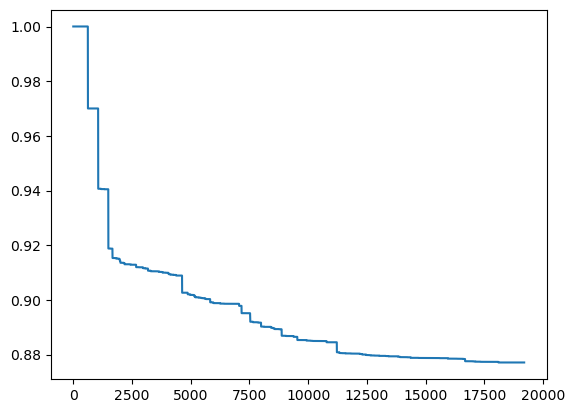

In [54]:
import matplotlib.pyplot as plt
plt.plot(obj.get_history_bestsofar())
plt.savefig('figure.png')

In [55]:
s[0]

960

In [56]:
# Define the parameter space for the COB
import nevergrad as ng

def gaussian(x, mu=1.0, sigma=0.5, a=2):
    return a * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

def compute_loss(cob, input_data, original_pred, layer_idx, original_loss,a=None,sigma_gaussian=None):
    # Set up model with the new COB
    teleported_model = LinearNet()
    teleported_model = NeuralTeleportationModel(teleported_model, input_shape=(1, 197, 192))

    # model.network.load_state_dict(original_mlp_0.state_dict())
    load_ln_weights(teleported_model, model, layer_idx)
    # teleported_model.set_weights(initial_weights)
    
    if args.teleport_gaussian:
        # check wheter all elements of cob are zero
        # TODO: maybe uncomment
        # if torch.all(cob == 0):
        #     cob = torch.ones_like(cob)
        if False:
            pass
        else:
            cob = gaussian(cob, mu=1.0, sigma=sigma_gaussian, a=a)

    teleported_model = teleported_model.teleport(cob, reset_teleportation=True)

    # Reset activation stats and run a forward pass
    activation_stats = {}
    for i, layer in enumerate(teleported_model.network.children()):
            if isinstance(layer, nn.ReLU) or isinstance(layer, ReLUCOB) or isinstance(layer, SigmoidCOB) or isinstance(layer, nn.Sigmoid) or isinstance(layer, GELUCOB) or isinstance(layer, nn.GELU) or isinstance(layer, LeakyReLUCOB) or isinstance(layer, nn.LeakyReLU):
                layer.register_forward_hook(activation_hook(f'relu_{i}',activation_stats=activation_stats))
    teleported_model.eval()
    pred = teleported_model.network(input_data)
    # teleported_model.train()

    # Compute loss based on activation stats
    loss = sum([stats['max'] - stats['min'] for stats in activation_stats.values()])
    loss /= original_loss
    # second term of loss - difference between the cob and the ones tensor
    # loss += 10 * (cob - torch.ones_like(cob)).abs().mean()
    pred_error = np.absolute(original_pred - pred.detach().cpu().numpy()).mean()
    pred_error /= np.abs(original_pred).mean()
    total_loss = loss + args.pred_mul * pred_error

    if random.random() < 0.01:
        print(f"Loss: {loss}, Prediction Error: {pred_error}, Total Loss: {total_loss}")

    return total_loss, pred_error, loss

# Define the function to minimize using Nevergrad
def ng_loss_function(cob_flat,a=None,sigma_gaussian=None,input_teleported_model=None, original_pred=None, layer_idx=None, original_loss=None):
    cob = torch.tensor(cob_flat)
    loss, pred_error,range_loss = compute_loss(cob, input_teleported_model, original_pred, layer_idx, original_loss, a=a, sigma_gaussian=sigma_gaussian)

    # if random.random() < 0.01:
    # print(f"Loss: {loss}, Prediction Error: {pred_error}")

    global best_loss, cor_best_pred_error, cor_best_range
    if best_loss is None or loss < best_loss:
        best_loss = loss
        cor_best_range = range_loss
        cor_best_pred_error = pred_error

    return [loss.item()]

In [57]:
# parametrization = ng.p.Instrumentation(
#     ng.p.Array(shape=(initial_cob.size()),lower=0.5,upper=1.2)
# )
# # Define Nevergrad optimizer
# # optimizer = ng.optimizers.OnePlusOne(parametrization=parametrization, budget=args.steps)
# # tmp = ng.optimizers.Chaining([ng.optimizers.CMAbounded,ng.optimizers.CMA],[150])
# optimizer = ng.optimizers.CMA(parametrization=parametrization, budget=args.steps)
# # optimizer = ng.optimizers.OnePlusOne(parametrization=parametrization, budget=args.steps)
# # optimizer.suggest(np.ones(initial_cob.size()))
# # optimizer.ask()

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="nevergrad")
# import cma
# warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)

In [58]:
import warnings
import cma
import logging

warnings.filterwarnings("ignore", category=UserWarning, module="nevergrad")
warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)

# switching off the INFO messages
logging.getLogger('nevergrad').setLevel(logging.WARNING)
# show only error messages of ezkl library
logging.getLogger('ezklearn').setLevel(logging.ERROR)
logging.getLogger('ezkl').setLevel(logging.ERROR)

In [59]:
# # define input_teleported_model (used in ng_loss_function)
# input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
# input_convs = torch.tensor(input_convs).view(1,3,224,224)
# input_teleported_model = model.split_n(input_convs,0,half=True)
# # save npy file
# np.save(args.prefix_dir + "input_teleported_model.npy", input_teleported_model.detach().numpy())

# # define original_pred (used in ng_loss_function)
# original_pred = model.blocks[0].mlp(model.blocks[0].norm2(input_teleported_model))

# # Perform optimization using Nevergrad
# import functools
# ng_loss_function_partial = functools.partial(ng_loss_function,\
#                                                 input_teleported_model=input_teleported_model, \
#                                                 original_pred=original_pred, \
#                                                 layer_idx=0)
# recommendation = optimizer.minimize(ng_loss_function_partial)

# # Extract the best COB found
# best_cob = recommendation.value[0][0]
# best_cob = torch.tensor(best_cob)

# print(f"Best COB found: {best_cob}")
# print(f"Loss associated with the best COB: {best_loss}")

In [60]:
# # print best candidate
# print(recommendation.value[0][0])
# print(best_loss)

In [61]:
#  # Apply best COB and save model weights
# LN = LinearNet()
# LN = NeuralTeleportationModel(LN, input_shape=(1, 197, 192))
# load_ln_weights(LN, model, 0)
# LN = LN.teleport(best_cob, reset_teleportation=True)
# torch.save(LN.network.state_dict(), args.prefix_dir + 'block0_cob_activation_norm_teleported.pth')

# # Export the optimized model to ONNX
# torch.onnx.export(LN.network, input_teleported_model, args.prefix_dir + 'block0_cob_activation_norm_teleported.onnx', verbose=False, export_params=True, opset_version=12, do_constant_folding=True, input_names=['input_0'], output_names=['output'])

# # Print final results
# print("Best COB found using Nevergrad.")

In [62]:
# Define the CSV file and write the header if it doesn't exist
import csv

csv_file_path = args.prefix_dir + 'all_settings.csv'
if not os.path.exists(csv_file_path):
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([
            'EXPERIMENT SETTINGS',
            'Model_Number', 'Layer_Index',
            # 'Activation_Loss', 'Prediction_Error',
            'Activation_Loss',
            'Input_Scale', 'Param_Scale', 'Scale_Rebase_Multiplier',
            'Lookup_Range_0', 'Lookup_Range_1', 'Logrows', 'Num_Rows', 'Num_cols', 'Total_Assignments',
            'Total_Constant_Size', 'Model_Output_Scales', 
            'Required_Range_Checks_0','Required_Range_Checks_1', 'Proof_Time_Seconds', 'Max_Memory' ,'Mean_Squared_Error', 'Mean_Abs_Percent_Error',
    ])
        

            # 'EXPERIMENT SETTINGS'
            # 'Model_Number', 'Layer_Index',
            # 'Activation_Loss',
            # 'Input_Scale', 'Param_Scale', 'Scale_Rebase_Multiplier',
            # 'Lookup_Range_0', 'Lookup_Range_1', 'Logrows', 'Num_Rows', 'Num_cols', 'Total_Assignments'
            # 'Total_Constant_Size', 'Model_Output_Scales', 
            # 'Required_Range_Checks_0','Required_Range_Checks_1', 'Proof_Time_Seconds', 'Max_Memory' ,'Mean_Squared_Error', 'Mean_Abs_Percent_Error'


In [63]:
import itertools
import functools
import copy



# args.input_param_scale = 12
# args.num_cols = 2

# array_param_visibility = ["private","fixed"]
# array_input_param_scale = [12,7]
# array_num_cols = [2,4,8,16,32]
# array_max_log_rows = [19,20,21,22,23]
# array_scale_rebase = [1,2]

# array_param_visibility = ["private","fixed"]
array_param_visibility = ["fixed"]
# array_input_param_scale = [12,7]
array_input_param_scale = [7]
# array_num_cols = [1,2,4,8,16,32]
array_num_cols = [4]
# array_max_log_rows = [19,20,21,22,23]
# array_max_log_rows = [19,20,21,22,23,24,25,-1]
array_max_log_rows = [20]
# array_scale_rebase = [1,2,-1]
array_scale_rebase = [1]

# iterate over all the possible combinations
combinations = list(itertools.product(array_param_visibility, array_input_param_scale, array_num_cols, array_max_log_rows, array_scale_rebase))

list_of_gaussian_teleportation = []
list_of_uniform_teleportation = [1,2,3,4,5,6,7,8,9,10,11]
dic_uniform_teleportation = {
    0: {"down_range": 0, "up_range": 2, "sigma": 0.15},
    1: {"down_range": 0.4, "up_range": 1.6, "sigma": 0.10},
    2: {"down_range": 0.25, "up_range": 1.7, "sigma": 0.05},
    3: {"down_range": 0.4, "up_range": 1.6, "sigma": 0.15},
    4: {"down_range": 0.4, "up_range": 1.6, "sigma": 0.15},
    5: {"down_range": 0.4, "up_range": 1.6, "sigma": 0.15},
    6: {"down_range": 0.4, "up_range": 1.6, "sigma": 0.15},
    7: {"down_range": 0.4, "up_range": 1.6, "sigma": 0.15},
    8: {"down_range": 0.4, "up_range": 1.6, "sigma": 0.15},
    9: {"down_range": 0.4, "up_range": 1.6, "sigma": 0.15},
    10: {"down_range": 0.4, "up_range": 1.6, "sigma": 0.15},
    11: {"down_range": 0.4, "up_range": 1.6, "sigma": 0.15},
}
list_of_no_teleportation = [0]

# with no gradient pytorch
with torch.no_grad():
    # iterate over all the possible combinations
    for p in combinations:
        param_visibility, input_param_scale, num_cols, max_log_rows, scale_rebase = p
        # string experiment_settings as comma separated values
        experiment_settings = f"{param_visibility}/{input_param_scale}/{num_cols}/{max_log_rows}/{scale_rebase}"
        print("========= START =========")
        print(f"input_param_scale: {input_param_scale}, num_cols: {num_cols}, max_log_rows: {max_log_rows}, param_visibility: {param_visibility}")

        # copy the model
        new_model = copy.deepcopy(model)
        
        for layer_idx in range(model.depth):
            # define the arguments of nevergrad
            args.teleport_gaussian = True if layer_idx in list_of_gaussian_teleportation else False

            if args.teleport_gaussian:
                args.lower = (-1)
                args.upper = 1
            elif layer_idx in list_of_uniform_teleportation:
                args.lower = dic_uniform_teleportation[layer_idx]["down_range"]
                # args.lower = 0
                args.upper = dic_uniform_teleportation[layer_idx]["up_range"]
                # args.upper = 2
            else:
                args.lower = 1 - 1e-6
                args.upper = 1 + 1e-6
            args.steps = 300 * 10
            args.sigma = 0.15
            args.pred_mul = 5
            args.a_gaussian = 5.5
            args.sigma_gaussian = 0.5
            args.optimizer_name = "HSCMA"

            # check the experiment_settings and layer_idx exists in the csv file
            with open(csv_file_path, mode='r') as file:
                reader = csv.reader(file)
                exist_flag = False
                for row in reader:
                    if row[0] == experiment_settings and int(row[2]) == layer_idx:
                        print(f"Experiment settings: {experiment_settings} and layer_idx: {layer_idx} already exists in the csv file.")
                        exist_flag = True
                        break
            if exist_flag:
                continue
                
    # #       TODO:
    #         if layer_idx >=2:
    #             continue

            # Hook for the intermediate output of the block
            original_mlp_idx = model.blocks[layer_idx].mlp
            activation_stats_idx = {}
            for i,layer in enumerate(original_mlp_idx.children()):
                if isinstance(layer, nn.ReLU) or isinstance(layer, nn.Sigmoid) or isinstance(layer, nn.GELU) or isinstance(layer, nn.LeakyReLU):
                    layer.register_forward_hook(activation_hook(f'relu_{i}', activation_stats=activation_stats_idx))

            # run the mlp model to find original_loss
            input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
            original_block_idx_pred = model.split_n(torch.tensor(input_convs).view(BATCHS,3,224,224),layer_idx,half=False)
            # print activation stats
            print(f"layer_idx: {layer_idx} , \t  activation_stats: {activation_stats_idx}")
            original_loss_idx = sum([stats['max'] - stats['min'] for stats in activation_stats_idx.values()])
            print("ORIGINAL LOSS:",original_loss_idx)

            # Load the teleported model
            teleported_model_idx = LinearNet()
            teleported_model_idx = NeuralTeleportationModel(teleported_model_idx, input_shape=(1, 197, 192))
            load_ln_weights(teleported_model_idx, model, layer_idx)

            # get initial weights and cob
            initial_weights_idx = teleported_model_idx.get_weights().detach()
            initial_cob_idx = teleported_model_idx.generate_random_cob(cob_range=args.cob_range, requires_grad=True,center=args.center,sampling_type=args.sample_type)

            # track best loss
            global best_loss
            best_loss = 1e9

            # # nevergrad optimization
            # parametrization = ng.p.Instrumentation(
            #     ng.p.Array(shape=(initial_cob_idx.size()),lower=0.5,upper=1.2)
            # )
            # optimizer = ng.optimizers.CMA(parametrization=parametrization, budget=args.steps)
            # optimizer.suggest(np.ones(initial_cob_idx.size()))

            # define input_teleported_model (used in ng_loss_function)
            input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
            input_convs = torch.tensor(input_convs).view(1,3,224,224)
            # input_teleported_model = model.split_n(input_convs,layer_idx,half=True)
            # instead of model using the copy_model to consider the previous layer teleportation to the input of the current layer
            input_teleported_model = new_model.split_n(input_convs,layer_idx,half=True)

            # save npy file using in python checking script
            np.save(args.prefix_dir + f"input_teleported_model_{layer_idx}.npy", input_teleported_model.detach().numpy())

            # define original_pred (used in ng_loss_function)
            input_org = model.split_n(input_convs,layer_idx,half=True)
            original_pred = model.blocks[layer_idx].mlp(model.blocks[layer_idx].norm2(input_org))

            # # Perform optimization using Nevergrad
            # ng_loss_function_partial = functools.partial(ng_loss_function,\
            #                                             input_teleported_model=input_teleported_model, \
            #                                             original_pred=original_pred, \
            #                                             layer_idx=layer_idx)

            # recommendation = optimizer.minimize(ng_loss_function_partial)

            # # Extract the best COB found
            # best_cob = recommendation.value[0][0]
            # best_cob = torch.tensor(best_cob)
            # print("BEST LOSS:",best_loss)

            # Apply best COB and save model weights
            LN = LinearNet()
            LN = NeuralTeleportationModel(LN, input_shape=(1, 197, 192))
            load_ln_weights(LN, model, layer_idx)
            # check whether the teleportation .pth already exists
            # TODO: uncomment
            # if os.path.exists(args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.pth'):
            #     print(f"block{layer_idx}_cob_activation_norm_teleported.pth already exists.")
            #     LN.network.load_state_dict(torch.load(args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.pth'))
            #     best_loss = torch.tensor(best_loss).detach().cpu()
            if False:
                print("NO WAY")
            else:
                # nevergrad optimization
                # if args.teleport_gaussian and layer_idx != 2 and layer_idx != 3:
                s = initial_cob_idx.size()
                if args.teleport_gaussian:
                    parametrization = ng.p.Instrumentation(
                        ng.p.Array(lower=args.lower,upper=args.upper,shape=(s)).set_mutation(sigma=args.sigma),
                        ng.p.Scalar(lower= args.a_gaussian - 3, upper= args.a_gaussian + 3).set_mutation(sigma=0.3),
                        ng.p.Scalar(lower= args.sigma_gaussian - 0.3, upper= args.sigma_gaussian + 0.3).set_mutation(sigma=0.05),
                    )
                    optimizer_cls = ng.optimizers.registry[args.optimizer_name]
                    optimizer = optimizer_cls(parametrization=parametrization, budget=args.steps)
                    # optimizer.suggest(np.zeros(s),args.a_gaussian,args.sigma_gaussian)
                # elif layer_idx!=2 and layer_idx != 3:
                else:
                    parametrization = ng.p.Instrumentation(
                        ng.p.Array(lower=args.lower,upper=args.upper,shape=(s)).set_mutation(sigma=dic_uniform_teleportation[layer_idx]["sigma"]),
                        # ng.p.Scalar(lower= 0, upper= 1e-9),
                        # ng.p.Scalar(lower= 0, upper= 1e-9),
                    )
                    
                    optimizer = ng.optimizers.CMA(parametrization=parametrization, budget=args.steps)
                    # optimizer.suggest(np.ones(initial_cob_idx.size()),args.a_gaussian,args.sigma_gaussian)
                    # optimizer.suggest(np.ones(initial_cob_idx.size()))
                
                # else:
                #     print("INJAM LAYER_IDX 2 OR 3====")

                # Perform optimization using Nevergrad
                ng_loss_function_partial = functools.partial(
                    ng_loss_function,
                    input_teleported_model=input_teleported_model,
                    original_pred=original_pred,
                    layer_idx=layer_idx,
                    original_loss = original_loss_idx
                )
                recommendation = optimizer.minimize(ng_loss_function_partial)

                # Extract the best COB found
                best_cob = recommendation.value[0][0]
                best_cob = torch.tensor(best_cob).detach().cpu()

                if args.teleport_gaussian:
                    best_a = recommendation.value[0][1]
                    best_sigma_gaussian = recommendation.value[0][2]
                else:
                    best_a = None
                    best_sigma_gaussian = None

                print("BEST LOSS:",best_loss, "\t cor_best_pred_error:",cor_best_pred_error, "\t cor_best_range:",cor_best_range)

                # Apply best COB and save model weights
                if layer_idx in list_of_no_teleportation:
                    print("====== NO TELEPORTATION =====")
                else:
                    if True:
                        if args.teleport_gaussian:
                            print("====== TELEPORTING USING GAUSSIAN =====")
                            LN = LN.teleport(gaussian(best_cob, mu=1.0, sigma=best_sigma_gaussian, a=best_a), reset_teleportation=True)
                        else:
                            print("====== TELEPORTING USING UNIFORM =====")
                            LN = LN.teleport(best_cob, reset_teleportation=True)
                torch.save(LN.network.state_dict(), args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.pth')

            # Apply the teleportation to the new_model (Using for computing the next layer inputs)
            sd = LN.network.state_dict()
            sd = {k: v for k, v in sd.items() if 'norm2' not in k}
            new_model.blocks[layer_idx].mlp.load_state_dict(sd)
            sd = LN.network.state_dict()
            sd = {k.replace('norm2.',''): v for k, v in sd.items() if 'norm2' in k}
            new_model.blocks[layer_idx].norm2.load_state_dict(sd)

            # Export the optimized model to ONNX
            torch.onnx.export(LN.network, input_teleported_model, args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.onnx', verbose=False, export_params=True, opset_version=15, do_constant_folding=True, input_names=['input_0'], output_names=['output'])

            # check the validation of the teleportation
            
            # 1.extract onnx corrosponding to the teleported model (in original onnx)
            input_path = args.prefix_dir + f"network_split_{layer_idx}_False.onnx"
            output_path = args.prefix_dir + f"block{layer_idx}_cob_activation_norm.onnx"
            input_names = [f"/blocks.{layer_idx}/Add_2_output_0"]
            output_names = [f"/blocks.{layer_idx}/mlp/fc2/Add_output_0"]
            onnx.utils.extract_model(input_path, output_path, input_names, output_names, check_model=True)
            
            # # 2. run the python code
            # print("===== RUNNING PYTHON CODE =====")
            # a = args.prefix_dir + f"input_teleported_model_{layer_idx}.npy"
            # b = args.prefix_dir + f"block{layer_idx}_cob_activation_norm_teleported.onnx"
            # !python onnx_inference.py \
            #     --input {a} --model1 {output_path} --model2 {b}
            # print("===== PYTHON CODE FINISHED =====")
            # time.sleep(5)

            # ezkl to find the resources possible reduction
            import ezkl
            run_args = ezkl.PyRunArgs()
            run_args.input_visibility = "public"
            
            # run_args.param_visibility = "private"
            run_args.param_visibility = param_visibility

            run_args.output_visibility = "public"

            # run_args.input_scale = args.input_param_scale
            run_args.input_scale = input_param_scale
            # run_args.param_scale = args.input_param_scale
            run_args.param_scale = input_param_scale

            # run_args.logrows = args.log_rows
            if max_log_rows != (-1):
                run_args.logrows = max_log_rows

            # run_args.num_inner_cols = args.num_cols
            run_args.num_inner_cols = num_cols

            # run_args.scale_rebase_multiplier = args.scale_rebase_multiplier
            if scale_rebase != (-1):
                run_args.scale_rebase_multiplier = scale_rebase

            run_args.variables = [('batch_size', BATCHS)]

            # get SRS
            ezkl.get_srs(logrows=run_args.logrows, commitment=ezkl.PyCommitments.KZG)

            name0 = f'block{layer_idx}_cob_activation_norm'
            name1 = f'block{layer_idx}_cob_activation_norm_teleported'
            rng = [name0,name1]

            for m in rng:
                print("==== Model:",m, " in Layer:",layer_idx,"====")

                if m == name0:
                    model_path = args.prefix_dir + f"block{layer_idx}_cob_activation_norm.onnx"
                    x = input_org.cpu().detach().numpy().reshape([-1]).tolist()
                else:
                    model_path = args.prefix_dir + f"block{layer_idx}_cob_activation_norm_teleported.onnx"
                    x = input_teleported_model.cpu().detach().numpy().reshape([-1]).tolist()

                # Generate the calibration data
                data = dict(input_data=[x])
                cal_path = os.path.join(args.prefix_dir + 'cal_data.json')
                json.dump(data, open(cal_path, 'w'))

                # settings_path = f'{args.prefix_dir} settings_{model}.json'
                settings_path = args.prefix_dir + f'settings_{m}_{layer_idx}.json'
                # res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
                # assert res == True

                # try:
                #     if scale_rebase != (-1):
                #         res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[input_param_scale],scale_rebase_multiplier=[scale_rebase],max_logrows=max_log_rows)
                #     elif max_log_rows != (-1):
                #         res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[input_param_scale],max_logrows=max_log_rows)
                #     else:
                #         res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[input_param_scale])
                # except:
                #     print("ERROR in calibration: ",m,layer_idx)
                #     res = False
                #     # write in the csv file
                #     with open(csv_file_path, mode='a', newline='') as file:
                #         writer = csv.writer(file)
                #         l = original_loss_idx if m == name0 else best_loss
                #         writer.writerow([
                #             experiment_settings,
                #             m,layer_idx,
                #             l,
                #             None, None, None,
                #             None, None, None, None, None, None,
                #             None, None, None, None, None, None, None, None
                #         ])
                #     continue

                # res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[args.input_param_scale],scale_rebase_multiplier=[args.scale_rebase_multiplier])
                # res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[args.input_param_scale])
                # assert res == True

                # extract the resources
                # settings = json.load(open(settings_path))
                # rg = settings.get('run_args', {})
                # input_scale = rg.get('input_scale', None)
                # param_scale = rg.get('param_scale', None)
                # output_scale = settings.get('model_output_scales', None)
                # scale_rebase_multiplier = rg.get('scale_rebase_multiplier', None)
                # lookup_range = rg.get('lookup_range', [None, None])
                # logrows = rg.get('logrows', None)
                # num_rows = settings.get('num_rows', None)
                # total_assignments = settings.get('total_assignments', None)
                # num_cols = rg.get('num_inner_cols', None)
                # total_constant_size = settings.get('total_const_size', None)
                
                # print(logrows, num_rows, num_cols ,lookup_range, scale_rebase_multiplier, output_scale)
                # print("===============================")

                # 'EXPERIMENT SETTINGS'
                # 'Model_Number', 'Layer_Index',
                # 'Activation_Loss',
                # 'Input_Scale', 'Param_Scale', 'Scale_Rebase_Multiplier',
                # 'Lookup_Range_0', 'Lookup_Range_1', 'Logrows', 'Num_Rows', 'Num_cols', 'Total_Assignments'
                # 'Total_Constant_Size', 'Model_Output_Scales', 
                # 'Required_Range_Checks_0','Required_Range_Checks_1', 'Proof_Time_Seconds', 'Max_Memory' ,'Mean_Squared_Error', 'Mean_Abs_Percent_Error'

                # activation loss is equal to the original loss if m is equal to name0 else it is the best loss
                activation_loss = original_loss_idx if m == name0 else best_loss

                # write the results to the csv file
                # with open(csv_file_path, mode='a', newline='') as file:
                #     writer = csv.writer(file)
                #     writer.writerow([
                #         experiment_settings,
                #         m,layer_idx,
                #         activation_loss.item(),
                #         input_scale, param_scale, scale_rebase_multiplier,
                #         lookup_range[0], lookup_range[1], logrows, num_rows, num_cols, total_assignments,
                #         total_constant_size, output_scale,
                #           None, None, None, None, None, None
                #     ])
            
            print("\n\n")

========= START =========
input_param_scale: 7, num_cols: 4, max_log_rows: 20, param_visibility: fixed
layer_idx: 0 , 	  activation_stats: {'relu_1': {'norm': tensor(476.6286), 'max': tensor(6.2171), 'min': tensor(-6.8579), 'shape': torch.Size([1, 197, 768])}}
ORIGINAL LOSS: tensor(13.0750)


/Users/mm6322/Phd research/nerual_transport/neuralteleportation/neuralteleportation/layers/neuron.py:310: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if torch.all(self.prev_cob == 1):
/Users/mm6322/Phd research/nerual_transport/neuralteleportation/neuralteleportation/layers/neuron.py:310: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if torch.all(self.prev_cob == 1):


Loss: 0.9999895691871643, Prediction Error: 2.0716381186502986e-05, Total Loss: 1.0000931024551392
Loss: 0.9999895691871643, Prediction Error: 2.072716597467661e-05, Total Loss: 1.0000932216644287
Loss: 0.9999885559082031, Prediction Error: 2.0719900930998847e-05, Total Loss: 1.0000921487808228
Loss: 0.9999895095825195, Prediction Error: 2.0773213691427372e-05, Total Loss: 1.0000933408737183
Loss: 0.9999884963035583, Prediction Error: 2.0748120732605457e-05, Total Loss: 1.0000922679901123
Loss: 0.9999895095825195, Prediction Error: 2.0728219169541262e-05, Total Loss: 1.0000931024551392
Loss: 0.9999885559082031, Prediction Error: 2.0706926079583354e-05, Total Loss: 1.0000921487808228
Loss: 0.9999905228614807, Prediction Error: 2.07237244467251e-05, Total Loss: 1.0000941753387451
Loss: 0.9999884963035583, Prediction Error: 2.068293724732939e-05, Total Loss: 1.0000919103622437
Loss: 0.9999885559082031, Prediction Error: 2.0709814634756185e-05, Total Loss: 1.0000921487808228


KeyboardInterrupt: 

In [59]:
# import itertools
# import functools


# # args.input_param_scale = 12
# # args.num_cols = 2

# array_param_visibility = ["private","fixed"]
# array_input_param_scale = [12,7]
# array_num_cols = [2,4,8,16,32]
# # array_max_log_rows = [19,20,21,22,23]
# array_max_log_rows = [20,21,22,23,24,25]
# array_scale_rebase = [1,2]

# # iterate over all the possible combinations
# combinations = list(itertools.product(array_param_visibility, array_input_param_scale, array_num_cols, array_max_log_rows, array_scale_rebase))


# for p in combinations:

#     param_visibility, input_param_scale, num_cols, max_log_rows, scale_rebase = p
#     # string experiment_settings as comma separated values
#     experiment_settings = f"{param_visibility}/{input_param_scale}/{num_cols}/{max_log_rows}/{scale_rebase}"
#     print("========= START =========")
#     print(f"input_param_scale: {input_param_scale}, num_cols: {num_cols}, max_log_rows: {max_log_rows}, param_visibility: {param_visibility}")

    
#     for layer_idx in range(model.depth):
        
#         # check the experiment_settings and layer_idx exists in the csv file
#         with open(csv_file_path, mode='r') as file:
#             reader = csv.reader(file)
#             exist_flag = False
#             for row in reader:
#                 if row[0] == experiment_settings and int(row[2]) == layer_idx:
#                     print(f"Experiment settings: {experiment_settings} and layer_idx: {layer_idx} already exists in the csv file.")
#                     exist_flag = True
#                     break

#         if exist_flag:
#             continue

#         # Hook for the intermediate output of the block
#         original_mlp_idx = model.blocks[layer_idx].mlp
#         activation_stats_idx = {}
#         for i,layer in enumerate(original_mlp_idx.children()):
#             if isinstance(layer, nn.ReLU) or isinstance(layer, nn.Sigmoid) or isinstance(layer, nn.GELU) or isinstance(layer, nn.LeakyReLU):
#                 layer.register_forward_hook(activation_hook(f'relu_{i}', activation_stats=activation_stats_idx))

#         # run the mlp model to find original_loss
#         input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
#         original_block_idx_pred = model.split_n(torch.tensor(input_convs).view(BATCHS,3,224,224),layer_idx,half=False)
#         # print activation stats
#         print(f"layer_idx: {layer_idx} , \t  activation_stats: {activation_stats_idx}")
#         original_loss_idx = sum([stats['max'] - stats['min'] for stats in activation_stats_idx.values()])
#         print("ORIGINAL LOSS:",original_loss_idx)

#         # Load the teleported model
#         teleported_model_idx = LinearNet()
#         teleported_model_idx = NeuralTeleportationModel(teleported_model_idx, input_shape=(1, 197, 192))
#         load_ln_weights(teleported_model_idx, model, layer_idx)

#         # get initial weights and cob
#         initial_weights_idx = teleported_model_idx.get_weights().detach()
#         initial_cob_idx = teleported_model_idx.generate_random_cob(cob_range=args.cob_range, requires_grad=True,center=args.center,sampling_type=args.sample_type)

#         # track best loss
#         global best_loss
#         best_loss = 1e9

#         # nevergrad optimization
#         parametrization = ng.p.Instrumentation(
#             ng.p.Array(shape=(initial_cob_idx.size()),lower=0.5,upper=1.2)
#         )
#         optimizer = ng.optimizers.CMA(parametrization=parametrization, budget=args.steps)
#         optimizer.suggest(np.ones(initial_cob_idx.size()))

#         # define input_teleported_model (used in ng_loss_function)
#         input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
#         input_convs = torch.tensor(input_convs).view(1,3,224,224)
#         input_teleported_model = model.split_n(input_convs,layer_idx,half=True)
#         # save npy file using in python checking script
#         np.save(args.prefix_dir + f"input_teleported_model_{layer_idx}.npy", input_teleported_model.detach().numpy())

#         # define original_pred (used in ng_loss_function)
#         original_pred = model.blocks[layer_idx].mlp(model.blocks[layer_idx].norm2(input_teleported_model))

#         # Perform optimization using Nevergrad
#         ng_loss_function_partial = functools.partial(ng_loss_function,\
#                                                     input_teleported_model=input_teleported_model, \
#                                                     original_pred=original_pred, \
#                                                     layer_idx=layer_idx)

#         recommendation = optimizer.minimize(ng_loss_function_partial)

#         # Extract the best COB found
#         best_cob = recommendation.value[0][0]
#         best_cob = torch.tensor(best_cob)
#         print("BEST LOSS:",best_loss)

#         # Apply best COB and save model weights
#         LN = LinearNet()
#         LN = NeuralTeleportationModel(LN, input_shape=(1, 197, 192))
#         load_ln_weights(LN, model, layer_idx)
#         LN = LN.teleport(best_cob, reset_teleportation=True)
#         torch.save(LN.network.state_dict(), args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.pth')

#         # Export the optimized model to ONNX
#         torch.onnx.export(LN.network, input_teleported_model, args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.onnx', verbose=False, export_params=True, opset_version=15, do_constant_folding=True, input_names=['input_0'], output_names=['output'])

#         # check the validation of the teleportation
        
#         # 1.extract onnx corrosponding to the teleported model (in original onnx)
#         input_path = args.prefix_dir + f"network_split_{layer_idx}_False.onnx"
#         output_path = args.prefix_dir + f"block{layer_idx}_cob_activation_norm.onnx"
#         input_names = [f"/blocks.{layer_idx}/Add_2_output_0"]
#         output_names = [f"/blocks.{layer_idx}/mlp/fc2/Add_output_0"]
#         onnx.utils.extract_model(input_path, output_path, input_names, output_names, check_model=True)
        
#         # # 2. run the python code
#         # print("===== RUNNING PYTHON CODE =====")
#         # a = args.prefix_dir + f"input_teleported_model_{layer_idx}.npy"
#         # b = args.prefix_dir + f"block{layer_idx}_cob_activation_norm_teleported.onnx"
#         # !python onnx_inference.py \
#         #     --input {a} --model1 {output_path} --model2 {b}
#         # print("===== PYTHON CODE FINISHED =====")
#         # time.sleep(5)

#         # ezkl to find the resources possible reduction
#         import ezkl
#         run_args = ezkl.PyRunArgs()
#         run_args.input_visibility = "public"
        
#         # run_args.param_visibility = "private"
#         run_args.param_visibility = param_visibility

#         run_args.output_visibility = "public"

#         # run_args.input_scale = args.input_param_scale
#         run_args.input_scale = input_param_scale
#         # run_args.param_scale = args.input_param_scale
#         run_args.param_scale = input_param_scale

#         # run_args.logrows = args.log_rows
#         run_args.logrows = max_log_rows

#         # run_args.num_inner_cols = args.num_cols
#         run_args.num_inner_cols = num_cols

#         # run_args.scale_rebase_multiplier = args.scale_rebase_multiplier
#         run_args.scale_rebase_multiplier = scale_rebase

#         run_args.variables = [('batch_size', BATCHS)]

#         # get SRS
#         ezkl.get_srs(logrows=run_args.logrows, commitment=ezkl.PyCommitments.KZG)

#         name0 = f'block{layer_idx}_cob_activation_norm'
#         name1 = f'block{layer_idx}_cob_activation_norm_teleported'
#         rng = [name0,name1]
        
#         # Generate the calibration data
#         x = input_teleported_model.cpu().detach().numpy().reshape([-1]).tolist()
#         data = dict(input_data=[x])
#         cal_path = os.path.join(args.prefix_dir + 'cal_data.json')
#         json.dump(data, open(cal_path, 'w'))

#         for m in rng:
#             print("==== Model:",m, " in Layer:",layer_idx,"====")

#             if m == name0:
#                 model_path = args.prefix_dir + f"block{layer_idx}_cob_activation_norm.onnx"
#             else:
#                 model_path = args.prefix_dir + f"block{layer_idx}_cob_activation_norm_teleported.onnx"

#             # settings_path = f'{args.prefix_dir} settings_{model}.json'
#             settings_path = args.prefix_dir + f'settings_{m}_{layer_idx}.json'

#             res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
#             assert res == True

#             try:
#                 res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[input_param_scale],scale_rebase_multiplier=[scale_rebase],max_logrows=max_log_rows)
#             except:
#                 print("ERROR in calibration: ",m,layer_idx)
#                 res = False
#                 # write in the csv file
#                 with open(csv_file_path, mode='a', newline='') as file:
#                     writer = csv.writer(file)
#                     l = original_loss_idx if m == name0 else best_loss
#                     writer.writerow([
#                         experiment_settings,
#                         m,layer_idx,
#                         l,
#                         None, None, None,
#                         None, None, None, None, None, None,
#                         None, None, None, None, None, None, None, None
#                     ])
#                 continue

#             # res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[args.input_param_scale],scale_rebase_multiplier=[args.scale_rebase_multiplier])
#             # res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[args.input_param_scale])

#             assert res == True

#             # extract the resources
#             settings = json.load(open(settings_path))
#             rg = settings.get('run_args', {})
#             input_scale = rg.get('input_scale', None)
#             param_scale = rg.get('param_scale', None)
#             output_scale = settings.get('model_output_scales', None)
#             scale_rebase_multiplier = rg.get('scale_rebase_multiplier', None)
#             lookup_range = rg.get('lookup_range', [None, None])
#             logrows = rg.get('logrows', None)
#             num_rows = settings.get('num_rows', None)
#             total_assignments = settings.get('total_assignments', None)
#             num_cols = rg.get('num_inner_cols', None)
#             total_constant_size = settings.get('total_const_size', None)
            
#             print(logrows, num_rows, num_cols ,lookup_range, scale_rebase_multiplier, output_scale)
#             print("===============================")

#             # 'EXPERIMENT SETTINGS'
#             # 'Model_Number', 'Layer_Index',
#             # 'Activation_Loss',
#             # 'Input_Scale', 'Param_Scale', 'Scale_Rebase_Multiplier',
#             # 'Lookup_Range_0', 'Lookup_Range_1', 'Logrows', 'Num_Rows', 'Num_cols', 'Total_Assignments'
#             # 'Total_Constant_Size', 'Model_Output_Scales', 
#             # 'Required_Range_Checks_0','Required_Range_Checks_1', 'Proof_Time_Seconds', 'Max_Memory' ,'Mean_Squared_Error', 'Mean_Abs_Percent_Error'

#             # activation loss is equal to the original loss if m is equal to name0 else it is the best loss
#             activation_loss = original_loss_idx if m == name0 else best_loss

#             # write the results to the csv file
#             with open(csv_file_path, mode='a', newline='') as file:
#                 writer = csv.writer(file)
#                 writer.writerow([
#                     experiment_settings,
#                     m,layer_idx,
#                     activation_loss.item(),
#                     input_scale, param_scale, scale_rebase_multiplier,
#                     lookup_range[0], lookup_range[1], logrows, num_rows, num_cols, total_assignments,
#                     total_constant_size, output_scale,
#                     None, None, None, None, None, None
#                 ])


In [60]:
# # extract onnx of the teleported model
# input_path = args.prefix_dir + "network_split_0_False.onnx"
# output_path = args.prefix_dir + "block0_cob_activation_norm.onnx"
# input_names = ["/blocks.0/Add_2_output_0"]
# output_names = ["/blocks.0/mlp/fc2/Add_output_0"]
# onnx.utils.extract_model(input_path, output_path, input_names, output_names, check_model=True)

In [61]:
# !python onnx_inference.py --input {args.prefix_dir + 'input_teleported_model.npy'} \
#     --model1 {args.prefix_dir + 'block0_cob_activation_norm.onnx'} \
#     --model2 {args.prefix_dir + 'block0_cob_activation_norm_teleported.onnx'}

In [62]:
# print important args related to ezkl
print("args.input_param_scale:",args.input_param_scale)
print("args.logrows:",args.log_rows)
print("args.num_cols:",args.num_cols)
print("args.scale_rebase_multiplier:",args.scale_rebase_multiplier)

args.input_param_scale: 7
args.logrows: 20
args.num_cols: 2
args.scale_rebase_multiplier: 1


In [63]:
import ezkl

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "public"
# TODO: change that to fixed
run_args.param_visibility = "fixed"
run_args.output_visibility = "public"
run_args.input_scale = args.input_param_scale
run_args.param_scale = args.input_param_scale
run_args.logrows = args.log_rows
run_args.num_inner_cols = args.num_cols
run_args.scale_rebase_multiplier = args.scale_rebase_multiplier
run_args.variables = [('batch_size', BATCHS)]

ezkl.get_srs(logrows=run_args.logrows, commitment=ezkl.PyCommitments.KZG)

<Future pending cb=[<builtins.PyDoneCallback object at 0x362e0d7b0>()]>

In [64]:
# print ezkl version
print("ezkl version:",ezkl.__version__)

ezkl version: 100.100.101


In [65]:
# source ~/.config/envman/PATH.env

In [66]:
# from torch.utils.data import SubsetRandomSampler

# # Loading the dataset
# dataset_test, args.nb_classes = build_dataset(is_train=False, args=args)

# # Create a random subset of indices for 10 samples
# subset_indices = torch.randperm(len(dataset_test))[:args.batch_size*100]

# # sampler_test = torch.utils.data.DistributedSampler(
# #         dataset_test, num_replicas=1, rank=0, shuffle=True, seed=args.seed)
# # Use SubsetRandomSampler to create a sampler for the subset
# sampler_test = SubsetRandomSampler(subset_indices)

# data_loader_test = torch.utils.data.DataLoader(
#     dataset_test, sampler=sampler_test,
#     batch_size=BATCHS,
#     num_workers=args.num_workers,
#     pin_memory=args.pin_mem,
#     drop_last=True,
# )

In [67]:
# !RUST_LOG=trace

# rng = ['block0_cob_activation_norm','block0_cob_activation_norm_teleported']

# # Generate the calibration data
# x = input_teleported_model.cpu().detach().numpy().reshape([-1]).tolist()
# data = dict(input_data=[x])
# cal_path = os.path.join(args.prefix_dir + 'cal_data.json')
# json.dump(data, open(cal_path, 'w'))

# for model in rng:

#     print("==== Model:",model, "====")

#     model_path = args.prefix_dir + model + ".onnx"
#     settings_path = f'{args.prefix_dir} settings_{model}.json'

#     res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
#     assert res == True

#     # res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[args.input_param_scale],scale_rebase_multiplier=[args.scale_rebase_multiplier],max_logrows=args.log_rows)
#     # res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[args.input_param_scale],scale_rebase_multiplier=[args.scale_rebase_multiplier])
#     res = await ezkl.calibrate_settings(cal_path, model_path, settings_path, "resources", scales=[args.input_param_scale])
#     assert res == True

In [68]:
# recreate and initialize the model
model = build_model(args, pretrained=False)
if "convnext" in args.model:
    checkpoint = torch.load(args.resume, map_location='cpu')
    model.load_state_dict(checkpoint["model"])
elif "vit" in args.model:
    print("loading ...")
    checkpoint = torch.load(args.resume, map_location='cpu')
    
    if args.pruning_method == "CAP":
        load_state_dict(model, checkpoint["state_dict"], prefix='', ignore_missing="relative_position_index")
    elif args.pruning_method == "DENSE":
        model.load_state_dict(checkpoint['model'])
    else:
        model.load_state_dict(checkpoint)
        
#     model.load_state_dict(checkpoint)
#     model.load_state_dict(checkpoint["state_dict"])
    
elif "deit" in args.model:
    checkpoint = torch.load(args.resume, map_location='cpu')
    model.load_state_dict(checkpoint["model"])

# transfer the model to the cpu
model = model.to('cpu')
model.eval()
for param in model.parameters():
    param.requires_grad = False

loading ...
index: 0 	 new_name: blocks.0.attn.qkv.weight
index: 1 	 new_name: blocks.1.attn.qkv.weight
index: 2 	 new_name: blocks.2.attn.qkv.weight
index: 3 	 new_name: blocks.3.attn.qkv.weight
index: 4 	 new_name: blocks.4.attn.qkv.weight
index: 5 	 new_name: blocks.5.attn.qkv.weight
index: 6 	 new_name: blocks.6.attn.qkv.weight
index: 7 	 new_name: blocks.7.attn.qkv.weight
index: 8 	 new_name: blocks.8.attn.qkv.weight
index: 9 	 new_name: blocks.9.attn.qkv.weight
index: 10 	 new_name: blocks.10.attn.qkv.weight
index: 11 	 new_name: blocks.11.attn.qkv.weight
index: 0 	 new_name: blocks.0.attn.qkv.bias
index: 1 	 new_name: blocks.1.attn.qkv.bias
index: 2 	 new_name: blocks.2.attn.qkv.bias
index: 3 	 new_name: blocks.3.attn.qkv.bias
index: 4 	 new_name: blocks.4.attn.qkv.bias
index: 5 	 new_name: blocks.5.attn.qkv.bias
index: 6 	 new_name: blocks.6.attn.qkv.bias
index: 7 	 new_name: blocks.7.attn.qkv.bias
index: 8 	 new_name: blocks.8.attn.qkv.bias
index: 9 	 new_name: blocks.9.attn.q

/var/folders/mh/wt0s4pwn1w52cl7dn_5mj92m0000gp/T/ipykernel_82733/2906073395.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.resume, map_loca

In [69]:
# op = model.blocks[0].mlp(model.blocks[0].norm2(input_teleported_model))

# op - original_pred

In [70]:
# tout = LN.network(input_teleported_model)
# (original_pred - tout).abs().mean()

In [71]:
# save all the original predictions in original_pred_array
original_pred_array = []
input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
input_convs = torch.tensor(input_convs).view(1,3,224,224)

for layer_idx in range(model.depth):    
    input_teleported_model = model.split_n(input_convs,layer_idx,half=True)
    original_pred = model.blocks[layer_idx].mlp(model.blocks[layer_idx].norm2(input_teleported_model))
    original_pred_array.append(original_pred)

In [72]:
# list error of each tleported layer independently (correct input (not teleported) for each layer)

input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
input_convs = torch.tensor(input_convs).view(1,3,224,224)

for layer_idx in range(model.depth):
    input_layer = model.split_n(input_convs,layer_idx,half=True)
    org_pred = model.blocks[layer_idx].mlp(model.blocks[layer_idx].norm2(input_layer))

    # Load the teleported model
    teleported_model = LinearNet()
    teleported_model = NeuralTeleportationModel(teleported_model, input_shape=(1, 197, 192))
    load_ln_weights(teleported_model, model, layer_idx)
    if os.path.exists(args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.pth'):
        teleported_model.network.load_state_dict(torch.load(args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.pth'))
    else:
        print(f"block{layer_idx}_cob_activation_norm_teleported.pth does not exist.")
        continue

    teleported_pred = teleported_model.network(input_layer)
    error = (org_pred - teleported_pred).abs().mean()
    error /= org_pred.abs().mean()
    print(f"Layer {layer_idx} error: {error}")
    

/var/folders/mh/wt0s4pwn1w52cl7dn_5mj92m0000gp/T/ipykernel_82733/3146665136.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teleported_model.network.load_state_dict(tor

Layer 0 error: 2.067991044896189e-05
Layer 1 error: 0.020641284063458443
Layer 2 error: 0.025099044665694237
Layer 3 error: 0.03929218277335167
Layer 4 error: 0.038576312363147736
Layer 5 error: 0.05051187053322792
Layer 6 error: 0.054717447608709335
Layer 7 error: 0.06668603420257568
Layer 8 error: 0.046443164348602295
Layer 9 error: 0.03850443661212921
Layer 10 error: 0.04973328113555908
Layer 11 error: 0.042438797652721405


In [73]:
# list error of each tleported layer independently (teleported input for each layer)
input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
input_convs = torch.tensor(input_convs).view(1,3,224,224)

for layer_idx in range(new_model.depth):
    input_teleported_model = new_model.split_n(input_convs,layer_idx,half=True)
    input_org = model.split_n(input_convs,layer_idx,half=True)

    original_pred = model.blocks[layer_idx].mlp(model.blocks[layer_idx].norm2(input_org))

    # Load the teleported model
    teleported_model = LinearNet()
    teleported_model = NeuralTeleportationModel(teleported_model, input_shape=(1, 197, 192))
    load_ln_weights(teleported_model, model, layer_idx)
    if os.path.exists(args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.pth'):
        teleported_model.network.load_state_dict(torch.load(args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.pth'))
    else:
        print(f"block{layer_idx}_cob_activation_norm_teleported.pth does not exist.")
        continue
    teleported_pred = teleported_model.network(input_teleported_model)
    
    error = (original_pred - teleported_pred).abs().mean()
    error /= original_pred.abs().mean()
    print(f"Layer {layer_idx} error: {error}")

/var/folders/mh/wt0s4pwn1w52cl7dn_5mj92m0000gp/T/ipykernel_82733/1111111726.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teleported_model.network.load_state_dict(tor

Layer 0 error: 2.067991044896189e-05
Layer 1 error: 0.020641284063458443
Layer 2 error: 0.025099044665694237
Layer 3 error: 0.08037974685430527
Layer 4 error: 0.0768611952662468
Layer 5 error: 0.09685797244310379
Layer 6 error: 0.10400263965129852
Layer 7 error: 0.12368219345808029
Layer 8 error: 0.13154716789722443
Layer 9 error: 0.14072823524475098
Layer 10 error: 0.1552278995513916
Layer 11 error: 0.12587790191173553


In [74]:
teleportation_applied_layers = [0,1,2,3,4,5,6,7,8,9,10,11]

# the copy_model is used to consider the previous layer teleportation to the input of the current layer (only layers in the teleportation_applied_layers are gonna be teleported)
copy_model = copy.deepcopy(model)
copy_model.eval()
for param in copy_model.parameters():
    param.requires_grad_(False)

for layer_idx in teleportation_applied_layers:
    # compute the original_pred_idx - IMPORTANT: PRVIOUS TELEPORTED LAYERS EFFECT THE INPUT OF THE CURRENT LAYER => pred_error WOULD BE DIFFERENT
    input_convs = json.load(open(args.prefix_dir + "input_convs.json"))["input_data"][0]
    input_convs = torch.tensor(input_convs).view(BATCHS,3,224,224)
    input_teleported_model = copy_model.split_n(input_convs,layer_idx,half=True)

    # original_pred_idx = model.blocks[layer_idx].mlp(model.blocks[layer_idx].norm2(input_teleported_model))
    original_pred_idx = original_pred_array[layer_idx]

    LN = LinearNet()
    LN = NeuralTeleportationModel(LN, input_shape=(1, 197, 192))
    load_ln_weights(LN, model, layer_idx)

    # check whether the teleportation .pth already exists
    if os.path.exists(args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.pth'):
        print(f"block{layer_idx}_cob_activation_norm_teleported.pth already exists.")
        LN.network.load_state_dict(torch.load(args.prefix_dir + f'block{layer_idx}_cob_activation_norm_teleported.pth'))
    else:
        # raise error
        raise Exception(f"block{layer_idx}_cob_activation_norm_teleported.pth does not exists.")

    # subsitude the teleported_model weights in the original model
    state_dic = LN.network.state_dict()
    state_dic = {k: v for k, v in state_dic.items() if 'norm2' not in k}
    copy_model.blocks[layer_idx].mlp.load_state_dict(state_dic)
    state_dic = LN.network.state_dict()
    state_dic = {k.replace('norm2.',''): v for k, v in state_dic.items() if 'norm2' in k}
    copy_model.blocks[layer_idx].norm2.load_state_dict(state_dic)

    # compute the prediction error
    new_pred = copy_model.blocks[layer_idx].mlp(copy_model.blocks[layer_idx].norm2(input_teleported_model))
    diff = (original_pred_idx - new_pred).abs().mean()
    print(f"Prediction error in layer {layer_idx}: {diff/original_pred_idx.abs().mean()}")

block0_cob_activation_norm_teleported.pth already exists.
Prediction error in layer 0: 0.0
block1_cob_activation_norm_teleported.pth already exists.
Prediction error in layer 1: 0.020641300827264786


/var/folders/mh/wt0s4pwn1w52cl7dn_5mj92m0000gp/T/ipykernel_82733/3984726627.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  LN.network.load_state_dict(torch.load(args.p

block2_cob_activation_norm_teleported.pth already exists.
Prediction error in layer 2: 0.025095244869589806
block3_cob_activation_norm_teleported.pth already exists.
Prediction error in layer 3: 0.08038013428449631
block4_cob_activation_norm_teleported.pth already exists.
Prediction error in layer 4: 0.07686309516429901
block5_cob_activation_norm_teleported.pth already exists.
Prediction error in layer 5: 0.09686117619276047
block6_cob_activation_norm_teleported.pth already exists.
Prediction error in layer 6: 0.10400275141000748
block7_cob_activation_norm_teleported.pth already exists.
Prediction error in layer 7: 0.12368261814117432
block8_cob_activation_norm_teleported.pth already exists.
Prediction error in layer 8: 0.13154645264148712
block9_cob_activation_norm_teleported.pth already exists.
Prediction error in layer 9: 0.14072991907596588
block10_cob_activation_norm_teleported.pth already exists.
Prediction error in layer 10: 0.1552288830280304
block11_cob_activation_norm_telepor

In [75]:
# # save the updated model .pth
torch.save(copy_model.state_dict(), args.resume.replace(".pth","_teleported.pth"))

In [76]:
x = transforms.ToTensor()(img).unsqueeze(0)

# export the updated model to onnx
torch.onnx.export(copy_model, x,\
                args.prefix_dir + 'complete_model_teleported.onnx', \
                verbose=False, export_params=True, opset_version=15, do_constant_folding=True, \
                input_names=['input'], output_names=['output'], \
                dynamic_axes={'input' : {0 : 'batch_size'},'output': {0:'batch_size'},},
)

# define the shape
on = onnx.load(args.prefix_dir + "complete_model_teleported.onnx")
for tensor in on.graph.input:
    for dim_proto in tensor.type.tensor_type.shape.dim:
        print("dim_proto:",dim_proto)
        if dim_proto.HasField("dim_param"): # and dim_proto.dim_param == 'batch_size':
            dim_proto.Clear()
            dim_proto.dim_value = BATCHS   # fixed batch size
for tensor in on.graph.output:
    for dim_proto in tensor.type.tensor_type.shape.dim:
        if dim_proto.HasField("dim_param"):
            dim_proto.Clear()
            dim_proto.dim_value = BATCHS   # fixed batch size
onnx.save(on, args.prefix_dir + "complete_model_teleported.onnx")

on = onnx.load(args.prefix_dir + "complete_model_teleported.onnx")
on = onnx.shape_inference.infer_shapes(on)
onnx.save(on, args.prefix_dir + "complete_model_teleported.onnx")

dim_proto: dim_param: "batch_size"

dim_proto: dim_value: 3

dim_proto: dim_value: 224

dim_proto: dim_value: 224



In [77]:
# export the splits of the model

input_path = args.prefix_dir + "complete_model_teleported.onnx"

# Convs layer
output_path = args.prefix_dir + "network_split_convs_teleported.onnx"
input_names = ["input"]
output_names = ["/Add_output_0"]

onnx.utils.extract_model(input_path, output_path, input_names, output_names, check_model=True)
input_names = output_names

for layer_idx in range(model.depth):
    for half in [True,False]:        
        output_path = f"{args.prefix_dir}network_split_{layer_idx}_{str(half)}_teleported.onnx"
        
        if half:
            output_names = [f"/blocks.{layer_idx}/Add_2_output_0"]
        else:
            output_names = [f"/blocks.{layer_idx}/Add_3_output_0"]
            
            if layer_idx == (model.depth - 1):
                output_names = ["output"]
                
        print("layer_idx:",layer_idx,"\t half:",str(half),"\t input_names:",input_names,"\t output_names:",output_names)
                
        onnx.utils.extract_model(input_path, output_path, input_names, output_names,check_model=True)
        input_names = output_names

layer_idx: 0 	 half: True 	 input_names: ['/Add_output_0'] 	 output_names: ['/blocks.0/Add_2_output_0']
layer_idx: 0 	 half: False 	 input_names: ['/blocks.0/Add_2_output_0'] 	 output_names: ['/blocks.0/Add_3_output_0']
layer_idx: 1 	 half: True 	 input_names: ['/blocks.0/Add_3_output_0'] 	 output_names: ['/blocks.1/Add_2_output_0']
layer_idx: 1 	 half: False 	 input_names: ['/blocks.1/Add_2_output_0'] 	 output_names: ['/blocks.1/Add_3_output_0']
layer_idx: 2 	 half: True 	 input_names: ['/blocks.1/Add_3_output_0'] 	 output_names: ['/blocks.2/Add_2_output_0']
layer_idx: 2 	 half: False 	 input_names: ['/blocks.2/Add_2_output_0'] 	 output_names: ['/blocks.2/Add_3_output_0']
layer_idx: 3 	 half: True 	 input_names: ['/blocks.2/Add_3_output_0'] 	 output_names: ['/blocks.3/Add_2_output_0']
layer_idx: 3 	 half: False 	 input_names: ['/blocks.3/Add_2_output_0'] 	 output_names: ['/blocks.3/Add_3_output_0']
layer_idx: 4 	 half: True 	 input_names: ['/blocks.3/Add_3_output_0'] 	 output_names: [

In [78]:
# from torch.utils.data import SubsetRandomSampler

# # Loading the dataset
# dataset_test, args.nb_classes = build_dataset(is_train=False, args=args)

# # Create a random subset of indices for 10 samples
# subset_indices = torch.randperm(len(dataset_test))[:args.batch_size*100]

# # sampler_test = torch.utils.data.DistributedSampler(
# #         dataset_test, num_replicas=1, rank=0, shuffle=True, seed=args.seed)
# # Use SubsetRandomSampler to create a sampler for the subset
# sampler_test = SubsetRandomSampler(subset_indices)

# data_loader_test = torch.utils.data.DataLoader(
#     dataset_test, sampler=sampler_test,
#     batch_size=BATCHS,
#     num_workers=args.num_workers,
#     pin_memory=args.pin_mem,
#     drop_last=True,
# )

# TODO:
# define the data_loader_test an iterator which only returns the img
img = Image.open("/Users/mm6322/Phd research/nerual_transport/neuralteleportation/neuralteleportation/experiments/sparse-cap-acc-tmp/ILSVRC2012_val_00000616.JPEG")
img = img.resize((224,224))
data = transforms.ToTensor()(img).unsqueeze(0)
# data_set_test = torch.utils.data.TensorDataset(data)
# contain data and label in the dataset
# label is shape 1,1000 which is one hot encoded
label = torch.tensor(1).unsqueeze(0) 
data_set_test = torch.utils.data.TensorDataset(data,label)
data_loader_test = torch.utils.data.DataLoader(data_set_test, batch_size=BATCHS, shuffle=True)
# data_loader_test = torch.utils.data.DataLoader(da)


In [79]:
import ezkl
import json
import onnx
import onnxruntime
import numpy as np
import sys


def get_ezkl_output(witness_file, settings_file):
    # convert the quantized ezkl output to float value
    witness_output = json.load(open(witness_file))
    outputs = witness_output['outputs']
    with open(settings_file) as f:
        settings = json.load(f)
    ezkl_outputs = [[ezkl.felt_to_float(
        outputs[i][j], settings['model_output_scales'][i]) for j in range(len(outputs[i]))] for i in range(len(outputs))]
    return ezkl_outputs


def get_onnx_output(model_file, input_file):
    # generate the ML model output from the ONNX file
    onnx_model = onnx.load(model_file)
    onnx.checker.check_model(onnx_model)

    with open(input_file) as f:
        inputs = json.load(f)
    # reshape the input to the model
    num_inputs = len(onnx_model.graph.input)

    onnx_input = dict()
    for i in range(num_inputs):
        input_node = onnx_model.graph.input[i]
        dims = []
        elem_type = input_node.type.tensor_type.elem_type
#         print("elem_type: ", elem_type)
        for dim in input_node.type.tensor_type.shape.dim:
            if dim.dim_value == 0:
                dims.append(1)
            else:
                dims.append(dim.dim_value)
        if elem_type == 6:
            inputs_onnx = np.array(inputs['input_data'][i]).astype(
                np.int32).reshape(dims)
        elif elem_type == 7:
            inputs_onnx = np.array(inputs['input_data'][i]).astype(
                np.int64).reshape(dims)
        elif elem_type == 9:
            inputs_onnx = np.array(inputs['input_data'][i]).astype(
                bool).reshape(dims)
        else:
            inputs_onnx = np.array(inputs['input_data'][i]).astype(
                np.float32).reshape(dims)
        onnx_input[input_node.name] = inputs_onnx
    try:
        onnx_session = onnxruntime.InferenceSession(model_file)
        onnx_output = onnx_session.run(None, onnx_input)
    except Exception as e:
        print("error: ", e)
        # onnx_output = inputs['output_data']
#     print("onnx ", onnx_output)
    return onnx_output[0]


def compare_outputs(zk_output, onnx_output):
    # calculate percentage difference between the 2 outputs (which are lists)
    res = []
    contains_sublist = any(isinstance(sub, list) for sub in zk_output)
    zip_object = zip(np.array(zk_output),
                     np.array(onnx_output))
    
    num_eq_zk_onnx = 0
    num_total = 0
    
    for (i, (list1_i, list2_i)) in enumerate(zip_object):
        diff = list1_i - list2_i
        # iterate and print the diffs  if they are greater than 0.0
        res.append(np.linalg.norm(diff,axis=(-1)))
        print("= index: ",i, "\t diff-norm: ",np.linalg.norm(diff,axis=(-1)),"\t zk_output: ",list1_i.shape, "\t onnx_output: ",list2_i.shape)
        
        if np.argmax(list1_i) == np.argmax(list2_i):
            num_eq_zk_onnx += 1
        num_total += 1
    
    print("Accuracy (zk_onnx): \t", num_eq_zk_onnx / num_total)
    acc_zk_onnx = num_eq_zk_onnx / num_total
    return res, acc_zk_onnx

In [80]:
# img = Image.open("/Users/mm6322/Phd research/nerual_transport/neuralteleportation/neuralteleportation/experiments/sparse-cap-acc-tmp/ILSVRC2012_val_00000616.JPEG")
# img = img.resize((224,224))
# data = transforms.ToTensor()(img).unsqueeze(0)
# data_set_test = torch.utils.data.TensorDataset(data)

# print("data.shape:",data.shape)

In [81]:
import tqdm

ezkl_outputs = np.empty((0,1000))
onnx_outputs = np.empty((0,1000))
labels = np.array([])

# Open log file for writing
log_file_path = os.path.join(args.prefix_dir, "log", "output_log.txt")
os.makedirs(os.path.dirname(log_file_path), exist_ok=True)

with open(log_file_path, 'a') as log_file:

    # Generate dataNum_input_convs.json  
    for index, (image, label) in enumerate(data_loader_test):
        # image = data
        # label = torch.tensor(1).unsqueeze(0)
        # index = 0
        
        print("index:",index,"\t image.shape:",image.shape)
        log_file.write(f"index: {index}\timage.shape: {image.shape}\n")
        log_file.flush()
        
        os.makedirs(args.prefix_dir + "ezkl_inputs/"+str(index),exist_ok=True)

        # remove batch dimension
        output = model(image)
        image = image.squeeze(0)

        pre_witness_path = None

        # computing witness (last witness is important)
        for i in ["convs"] + [t for t in range(model.depth)]:
            for half in ["True","False"]:

                if i=="convs" and half=="False":
                    continue

                # Define paths
                if i == "convs":
                    model_path = args.prefix_dir + f"network_split_{i}_teleported.onnx"
                    settings_path = args.prefix_dir + f"ezkl_inputs/{index}/settings_split_{i}.json"
                    data_path = args.prefix_dir + f"ezkl_inputs/{index}/input_{i}.json"
                    compiled_model_path = args.prefix_dir + f"ezkl_inputs/{index}/network_split_{i}.compiled"
                    witness_path = args.prefix_dir + f"ezkl_inputs/{index}/witness_split_{i}.json"
                else:
                    model_path = args.prefix_dir + f"network_split_{i}_{half}_teleported.onnx"
                    settings_path = args.prefix_dir + f"ezkl_inputs/{index}/settings_split_{i}_{half}.json"
                    data_path = args.prefix_dir + f"ezkl_inputs/{index}/input_{i}_{half}.json"
                    compiled_model_path = args.prefix_dir + f"ezkl_inputs/{index}/network_split_{i}_{half}.compiled"
                    witness_path = args.prefix_dir + f"ezkl_inputs/{index}/witness_split_{i}_{half}.json"

                # Generating input data
                if i == "convs":
                    data = dict(input_data = [((image).detach().numpy()).reshape([-1]).tolist()])
                else:
                    inter_i = model.split_n(image,i,half=half)
                    data = dict(input_data = [((inter_i).detach().numpy()).reshape([-1]).tolist()])
                json.dump(data, open(data_path, 'w' ))


                # Swapping (output pre_witness -> cur_input of data_path)
                if i != "convs":
                    with open(pre_witness_path, 'r') as prev_witness_file:
                        prev_witness_data = json.load(prev_witness_file)
                        outputs = prev_witness_data['outputs']
                        tmp = {"input_data": outputs}
                        with open(data_path, 'w') as data_file:
                            json.dump(tmp, data_file) 

                # Generate setting
                res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
                assert res == True
                

                # Calibrating setting
    #                 res = ezkl.calibrate_settings(data_path, model_path, settings_path, "resources", \
    #                                               scales=[run_args.input_scale],max_logrows=run_args.logrows, scale_rebase_multiplier=[1],lookup_safety_margin=1)
                # Compile circuit
                res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
                assert res == True

                # Generating witness
                res = await ezkl.gen_witness(data_path, compiled_model_path, witness_path)
                assert os.path.isfile(witness_path)

                # Update input_scale
                settings = json.load(open(settings_path, 'r'))
                run_args.input_scale = settings["model_output_scales"][0]

                # Update pre_witness_path
                pre_witness_path = witness_path

    # check accuracy
    model_file = args.prefix_dir + "network_complete.onnx" 
    input_file = args.prefix_dir + f"ezkl_inputs/{index}/input_convs.json"
    witness_file = args.prefix_dir + f"ezkl_inputs/{index}/witness_split_{model.depth-1}_False.json"
    settings_file = args.prefix_dir + f"ezkl_inputs/{index}/settings_split_{model.depth-1}_False.json"

    # get the ezkl output
    ezkl_output = get_ezkl_output(witness_file, settings_file)
    ezkl_output = np.array(ezkl_output).reshape(BATCHS,1000)
    # get the onnx output
    onnx_output = get_onnx_output(model_file, input_file)

    ezkl_outputs = np.concatenate((ezkl_outputs,ezkl_output),axis=0)
    onnx_outputs = np.concatenate((onnx_outputs,onnx_output),axis=0)
    labels = np.concatenate((labels,label),axis=0)

    print("=====")
    log_file.write("=====\n")
    _,acc_zk_onnx = compare_outputs(ezkl_outputs, onnx_outputs)
    log_file.write(f"Accuracy (zk_onnx): \t {acc_zk_onnx}\n")
    
    acc_zk_label = np.sum( (labels) == np.argmax(ezkl_outputs,axis=(-1)) ) / len(labels)
    print("Accuracy (zk_label): \t", acc_zk_label)
    log_file.write(f"Accuracy (zk_label): \t {acc_zk_label}\n")
    
    acc_onnx_label = np.sum( (labels) == np.argmax(onnx_outputs,axis=(-1)) ) / len(labels)
    print("Accuracy (onnx_label): \t", acc_onnx_label)
    log_file.write(f"Accuracy (onnx_label): \t {acc_onnx_label}\n")
    
    print("=====\n\n")
    log_file.write("=====\n\n")
    log_file.flush()
    
    
    # compare the outputs
    percentage_difference,acc_zk_onnx = compare_outputs(ezkl_outputs, onnx_outputs)
    log_file.write(f"Accuracy (zk_onnx): \t {acc_zk_onnx}\n")

    # compare zk_output and truth_label
    acc_zk_label = np.sum( (labels) == np.argmax(ezkl_outputs,axis=(-1)) ) / len(labels)
    print("Accuracy (zk_label)", acc_zk_label)
    log_file.write(f"Accuracy (zk_label) {acc_zk_label}\n")

    # print the percentage difference
    mean_percentage_difference = np.mean(np.abs(percentage_difference))
    max_percentage_difference = np.max(np.abs(percentage_difference))
    print("mean norm diff: ", mean_percentage_difference)
    print("max norm diff: ", max_percentage_difference)
    log_file.write(f"mean norm diff: {mean_percentage_difference}\n")
    log_file.write(f"max norm diff: {max_percentage_difference}\n")

index: 0 	 image.shape: torch.Size([1, 3, 224, 224])
=====
= index:  0 	 diff-norm:  20.417514179257797 	 zk_output:  (1000,) 	 onnx_output:  (1000,)
Accuracy (zk_onnx): 	 1.0
Accuracy (zk_label): 	 0.0
Accuracy (onnx_label): 	 0.0
=====


= index:  0 	 diff-norm:  20.417514179257797 	 zk_output:  (1000,) 	 onnx_output:  (1000,)
Accuracy (zk_onnx): 	 1.0
Accuracy (zk_label) 0.0
mean norm diff:  20.417514179257797
max norm diff:  20.417514179257797


dim_proto: dim_value: 1

dim_proto: dim_value: 197

dim_proto: dim_value: 192

